# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/UNI/ANN/Homework2

Mounted at /gdrive
/gdrive/My Drive/UNI/ANN/Homework2


## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import math

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import ops
import tensorflow.keras.backend as K

!pip install keras-cv
import keras_cv as tfkcv
from keras_cv import layers as tfkcvl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 39.2 MB/s eta 0:00:00
TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [3]:
!pip install -U 'git+https://github.com/albumentations-team/albumentations'

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-l4ueli82
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-l4ueli82
  Resolved https://github.com/albumentations-team/albumentations to commit b86942a743bad73c7a6ef12728c5b55f43e174e5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 14.7 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.22-py3-none-any.whl size=259118 sha256=1ce5c1e3f8511c6e77c1eb85cc1918512b79006d548ae178123ce3e963806b7e
  Stored in directory: /tmp/pip-ephem-wheel-cache-efp6y_d7/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albu

In [4]:
import albumentations as alb #A in official documentation
import cv2

## ⏳ Load the Data

In [5]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


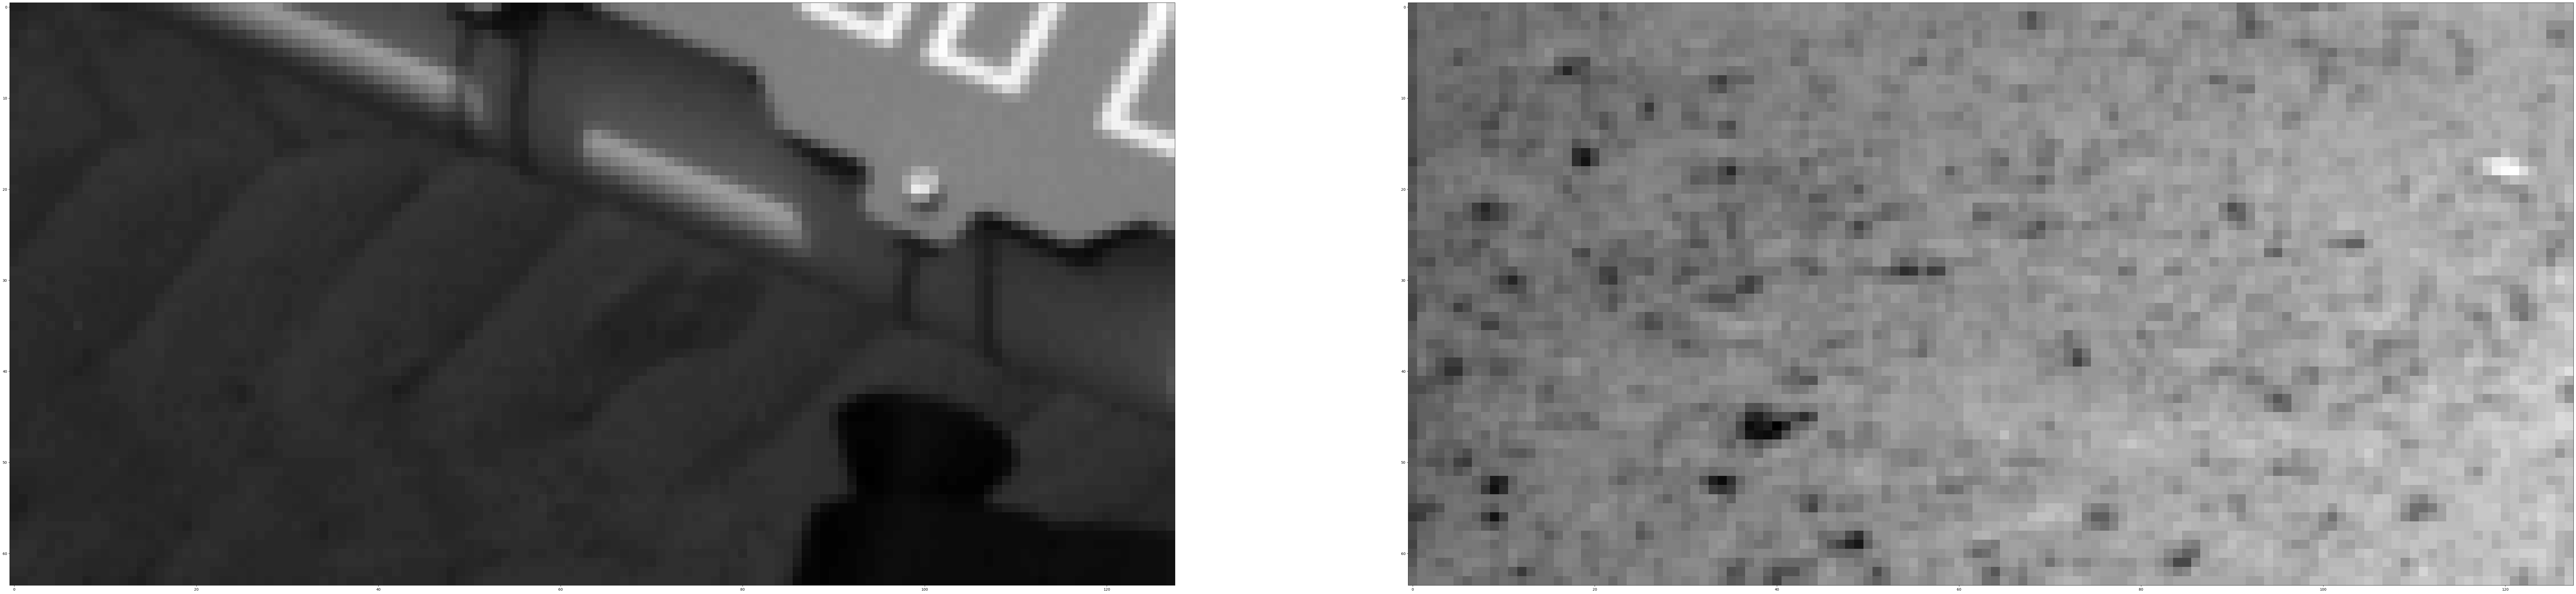

In [6]:
to_print = [8, 66]

fig, axes = plt.subplots(1, len(to_print), figsize=(128, 64))
for i, idx in enumerate(to_print):
    axes[i].imshow(X_train[idx], cmap="gray")

# 🗺 Data exploration

## Print some random images

In [ ]:
# Print some random images from X_train with the relative y_train image printed on top
num_images = 10
indices = np.random.choice(len(X_train), size=num_images, replace=False)

fig, axes = plt.subplots(num_images, 2, figsize=(10, 20))
for i, idx in enumerate(indices):
    ax1, ax2 = axes[i]
    ax1.imshow(X_train[idx], cmap="gray")
    ax1.set_title(f"X_train[{idx}]")
    ax2.imshow(y_train[idx])
    ax2.set_title(f"y_train[{idx}]")
    ax1.axis("off")
    ax2.axis("off")
plt.tight_layout()
plt.show()

## Print tha values of y_train

In [ ]:
# Print some random images from y_train showing the actual value of the pixels
num_images = 10
indices = np.random.choice(len(y_train), size=num_images, replace=False)

fig, axes = plt.subplots(num_images, 2, figsize=(10, 20))
for i, idx in enumerate(indices):
    ax1, ax2 = axes[i]
    ax1.imshow(y_train[idx])
    ax1.set_title(f"y_train[{idx}]")
    ax2.hist(y_train[idx].flatten(), bins=100)
    ax2.set_title(f"y_train[{idx}] histogram")
    ax1.axis("off")
    ax2.set_xlabel("Pixel value")
    ax2.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

## Test set exploration

In [ ]:
# Print some random images from X_test
num_images = 20
indices = np.random.choice(len(X_test), size=num_images, replace=False)

fig, axes = plt.subplots(num_images, 1, figsize=(128, 64))
for i, idx in enumerate(indices):
    ax = axes[i]
    ax.imshow(X_test[idx], cmap="gray")
    ax.set_title(f"X_test[{idx}]")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Search for outliers

## PCA

Perform PCA on both the training and test set to identify possible outliers

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

In [ ]:
h, w, c = X_train[0].shape
X_train_flat = X_train.reshape((len(X_train), h*w*c))
print(X_train_flat.shape)

h, w, c = X_test[0].shape
X_test_flat = X_test.reshape((len(X_test), h*w*c))
print(X_test_flat.shape)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# Plot the first two PCA components of training and test in two different plots
fig, axes = plt.subplots(1, 2, figsize=(12,12))
axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], label='Training set')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PCA of training set')
axes[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], label='Test set')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('PCA of test set')
plt.show()

In [ ]:
# Find outliers
outliers = (X_train_pca[:,1] > 5) + (X_train_pca[:,1] < -5)

# Visualisation of outliers
unique_outliers = np.unique(X_train[outliers], axis=0)
print(f"Number of outliers: {len(X_train[outliers])}")


num_outliers = len(unique_outliers)
print("Unique outliers: ", num_outliers)
cols = min(10, num_outliers)  # Set a maximum number of columns
rows = math.ceil(num_outliers / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten() if num_outliers > 1 else [axes]


for i, outlier in enumerate(unique_outliers):
    axes[i].imshow(outlier, cmap="gray")
    axes[i].axis('off')

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Unique Outliers', fontsize=50)
plt.tight_layout()
plt.show()

## T-SNE

Perform T-SNE on both training and test set to identify possible outliers

In [ ]:
# t-SNE for anomaly detection
from sklearn.manifold import TSNE

h, w, c = X_train[0].shape
X_train_flat = X_train.reshape((len(X_train), h*w*c))
print(X_train_flat.shape)

h, w, c = X_test[0].shape
X_test_flat = X_test.reshape((len(X_test), h*w*c))
print(X_test_flat.shape)

X_train_scores_tsne = TSNE(n_components=2,perplexity=70).fit_transform(X_train_flat)
X_test_scores_tsne = TSNE(n_components=2,perplexity=70).fit_transform(X_test_flat)

fig, axes = plt.subplots(1, 2, figsize=(12,12))
axes[0].scatter(X_train_scores_tsne[:, 0], X_train_scores_tsne[:, 1], label='Training set')
axes[0].set_xlabel('t-SNE1')
axes[0].set_ylabel('t-SNE2')
axes[0].set_title('t-SNE of training set')
axes[1].scatter(X_test_scores_tsne[:, 0], X_test_scores_tsne[:, 1], label='Test set')
axes[1].set_xlabel('t-SNE1')
axes[1].set_ylabel('t-SNE2')
axes[1].set_title('t-SNE of test set')
plt.show()

In [ ]:
# Find outliers
outliers = (X_train_scores_tsne[:,1] > 5) + (X_train_scores_tsne[:,1] < -5)

# Visualisation of outliers
unique_outliers = np.unique(X_train[outliers], axis=0)
print(f"Number of outliers: {len(X_train[outliers])}")


num_outliers = len(unique_outliers)
print("Unique outliers: ", num_outliers)
cols = min(10, num_outliers)  # Set a maximum number of columns
rows = math.ceil(num_outliers / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten() if num_outliers > 1 else [axes]


for i, outlier in enumerate(unique_outliers):
    axes[i].imshow(outlier, cmap="gray")
    axes[i].axis('off')

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Unique Outliers', fontsize=50)
plt.tight_layout()
plt.show()

# 👽 Remove Aliens

In [7]:
outliers = [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057,
            1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816,
            1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]

# outliers = [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057,
#             1079, 1082, xxxx, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816,
#             1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, xxxx, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, xxxx]

print(f"Number of outliers: {len(outliers)}")

Number of outliers: 110


In [8]:
X_train = np.delete(X_train, outliers, axis=0)
y_train = np.delete(y_train, outliers, axis=0)

# 🛠️ Train and Save the Model

In [9]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [10]:
# Training Hyperparameters

EPOCHS = 1000
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
NUM_CLASSES = 5
PATIENCE = 100
seed = 42

In [11]:
# Splitting X_train and y_train in training and validation dataset
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Create tensorflow datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

## Augmentation new (Albumentations)

### Settings

In [49]:
#probabilità indipendente di applicare una certa augmentation per ogni imagine
augmentation_probability = [
    {
      "geometric": 0.7,
      "flip": 0.7,
      "dropout": 0.7,
      "gaussianBlur": 0.7,
    },
    {
      "geometric": 0.7,
      "flip": 0.7,
      "dropout": 0.7,
      "gaussianBlur": 0.7,
    },
    {
      "geometric": 0.7,
      "flip": 0.7,
      "dropout": 0.7,
      "gaussianBlur": 0.7,
    },
    ]


#verfica e rimozione di immagini che non hanno subito augmentation ed eventuale rimozione
remove_duplicates = True

n_iterations = 3

### support functions

In [51]:
def display_aug(img, label, title=" "):

  fig, axes = plt.subplots(1, 2, figsize=(10, 20))
  ax1, ax2 = axes[0], axes[1]  # Corrected line
  ax1.imshow(img, cmap="gray")
  ax2.imshow(label)

  # Add titles to the subplots
  ax1.set_title(f"{title}")
  ax2.set_title(f"{title} map")  # Set title from the input argument

  ax1.axis("off")
  ax2.axis("off")
  plt.tight_layout()
  plt.show()


def create_augmentation_pipeline(probability):
  return [
    #affine = zoom + rotation + translation + shear
    #deve essere eseguito per primo per evitare problemi
    alb.Affine(
        scale=(0.99,1.3),
        translate_percent= 0.1,
        rotate = (-25,25),
        mode=1,  # 1 == cv2.BORDER_REPLICATE alternative: ['cv2.BORDER_CONSTANT', 'cv2.BORDER_REPLICATE', 'cv2.BORDER_REFLECT', 'cv2.BORDER_WRAP', 'cv2.BORDER_DEFAULT', 'cv2.BORDER_TRANSPARENT']
        keep_ratio=True,p=probability["geometric"]
    ),
    alb.HorizontalFlip(p=probability["flip"]),
    alb.CoarseDropout(num_holes_range=(1,150),hole_height_range=(1,3), hole_width_range=(1,3), p=probability["dropout"]),
    alb.GaussianBlur(blur_limit=(1, 3), p=probability["gaussianBlur"]),
  ]



def apply_augmentation_to_dataset(X_train, y_train, probability):
    # Create the augmentation pipeline once, before using it in the dataset map
    augmentation_pipeline = create_augmentation_pipeline(probability)
    transform = alb.Compose(augmentation_pipeline)

    augmented_X_train = []
    augmented_y_train = []

    for i in range(len(X_train)):
        transformed = transform(image=X_train[i], mask=y_train[i])
        augmented_X_train.append(transformed['image'])
        augmented_y_train.append(transformed['mask'])

    return augmented_X_train, augmented_y_train

In [52]:
import hashlib
def remove_duplicates(X_train, y_train, print_duplicates):
    """
    Remove duplicate images based on hash values after merging the datasets.
    Prints duplicate images when found.
    Returns unique images and their corresponding labels.
    """
    unique_images = []
    unique_labels = []
    seen_hashes = set()

    n_duplicates = 0

    for img, label in zip(X_train, y_train):
        # Hash the image to create a unique identifier
        img_hash = hashlib.md5(img.tobytes()).hexdigest()
        if img_hash not in seen_hashes:
            seen_hashes.add(img_hash)
            unique_images.append(img)
            unique_labels.append(label)
        elif print_duplicates:
            # If the image is a duplicate, print the two identical images
            print("Duplicate found:")
            #print("Image: ", img)
            display_aug(img, label)
            n_duplicates+=1
        else:
            n_duplicates+=1

    print("Number of duplicates generated from augmentation: ", n_duplicates)
    return np.array(unique_images), np.array(unique_labels)

def merge_dataset(X_train, y_train, augmented_X_train, augmented_y_train, remove_duplicates_flag=True, print_duplicates=False):
    # Merge the datasets first
    merged_X_train = np.concatenate((X_train, augmented_X_train), axis=0)
    merged_y_train = np.concatenate((y_train, augmented_y_train), axis=0)

    # Remove duplicates from the merged dataset
    if(remove_duplicates):
      merged_X_train, merged_y_train = remove_duplicates(merged_X_train, merged_y_train, print_duplicates)

    return merged_X_train, merged_y_train

### application (single iteration)

In [32]:
augmented_dataset = apply_augmentation_to_dataset(X_train, y_train, augmentation_probability[0])

Sample 1:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:0.0 0.0 0.0
test pixel augmented:0.0 0.0 0.0


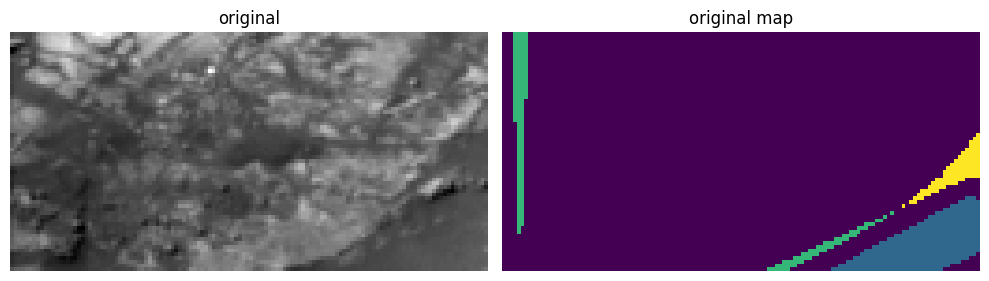

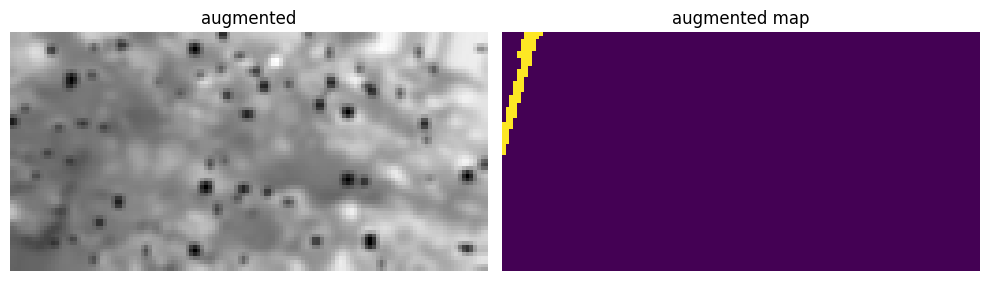

Sample 2:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


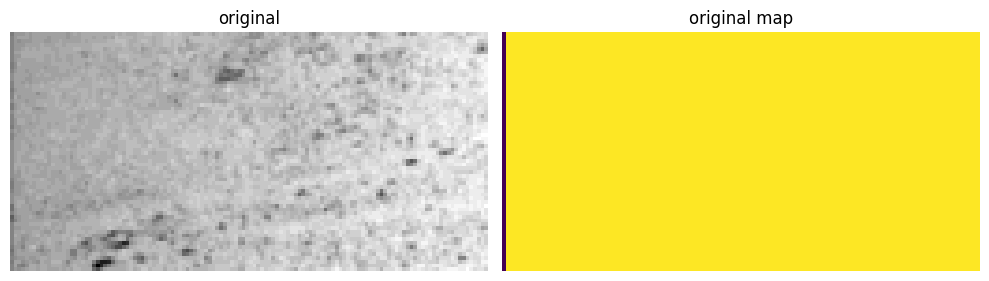

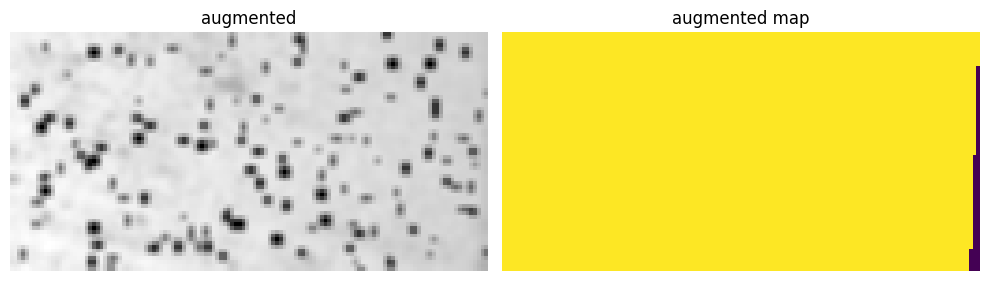

Sample 3:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:0.0 0.0 0.0
test pixel augmented:0.0 0.0 0.0


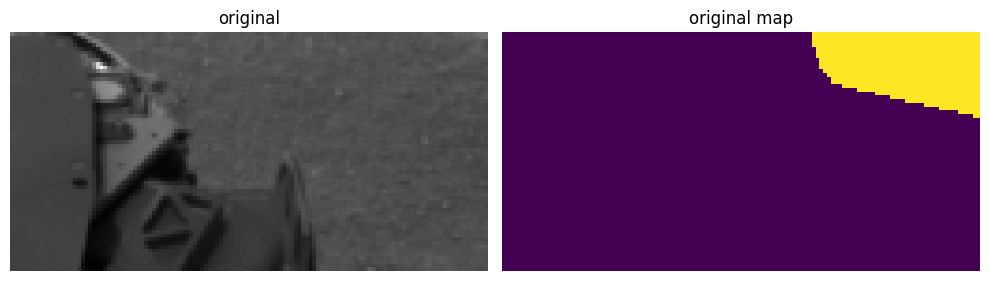

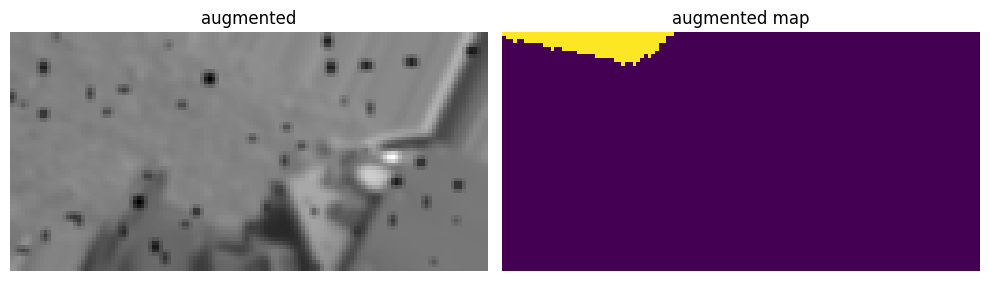

Sample 4:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


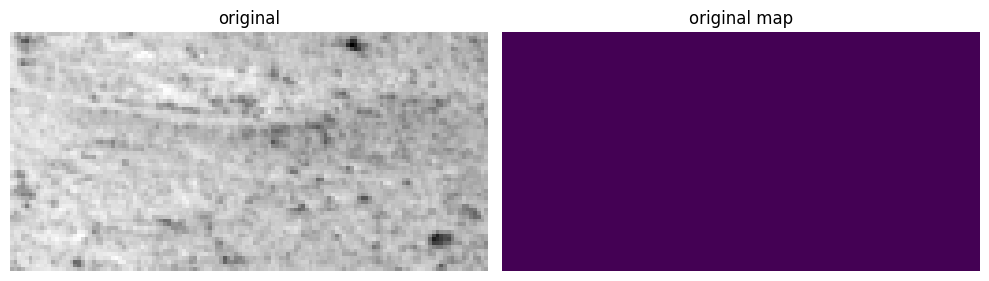

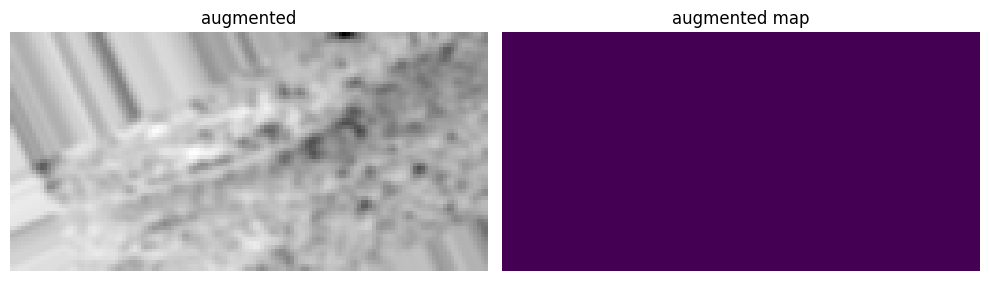

Sample 5:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 0.0
test pixel augmented:1.0 1.0 1.0


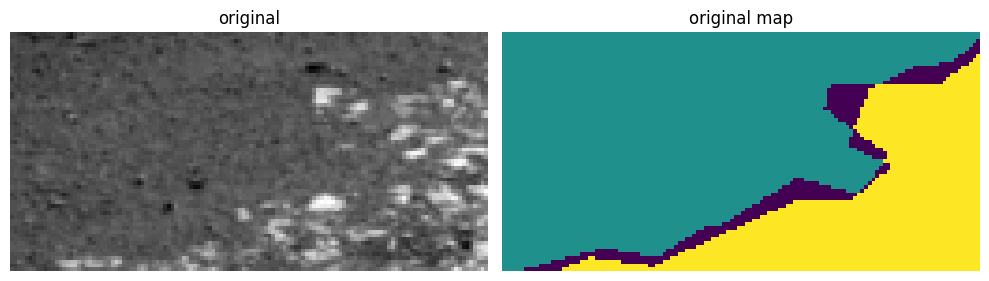

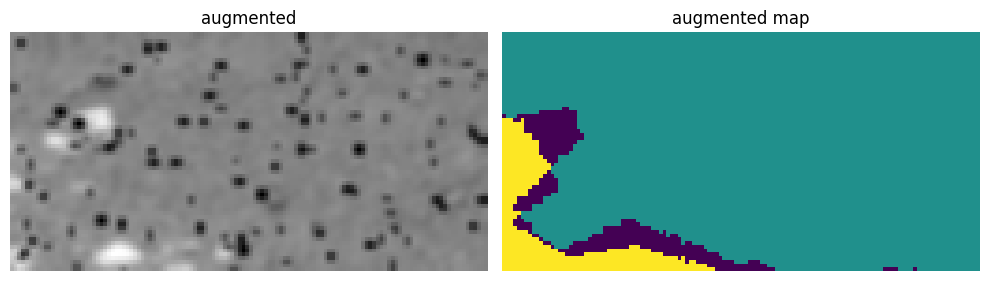

Sample 6:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


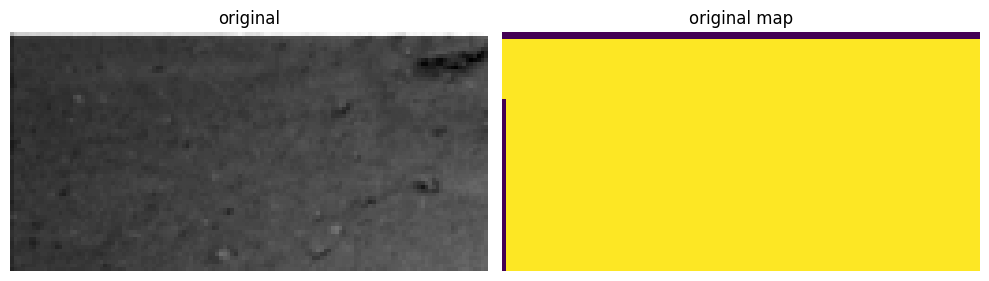

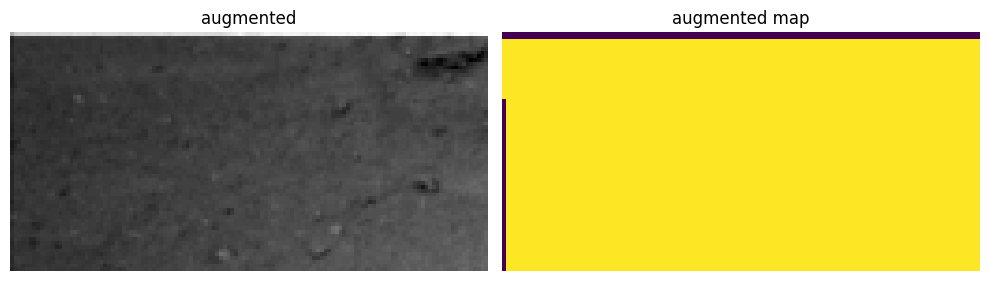

Sample 7:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


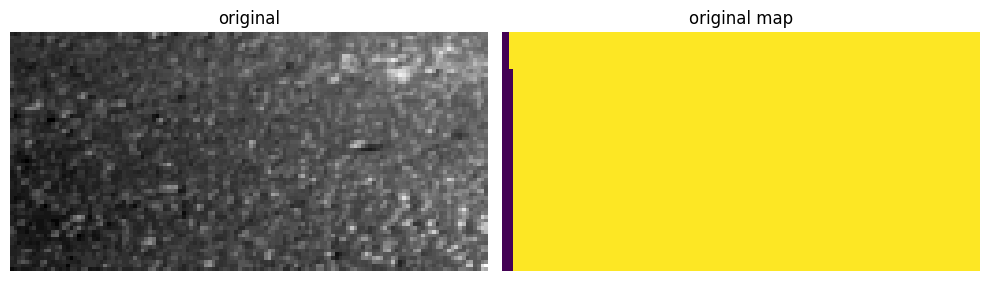

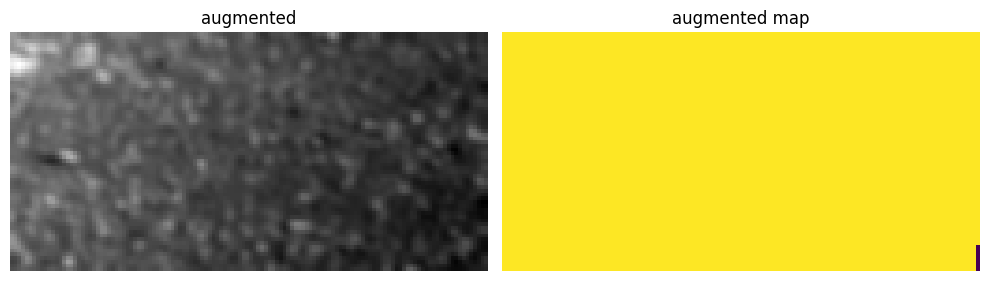

Sample 8:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


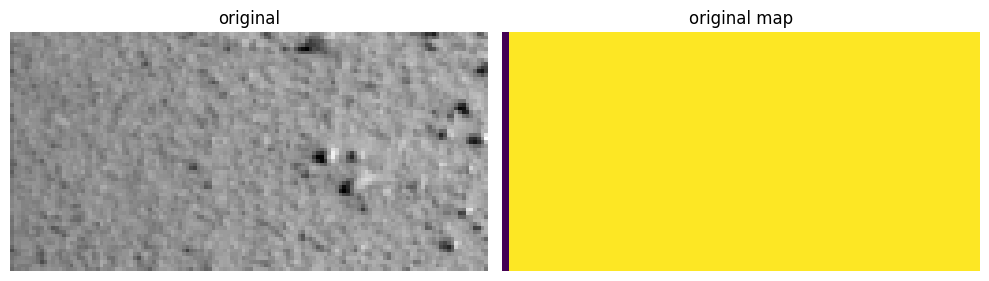

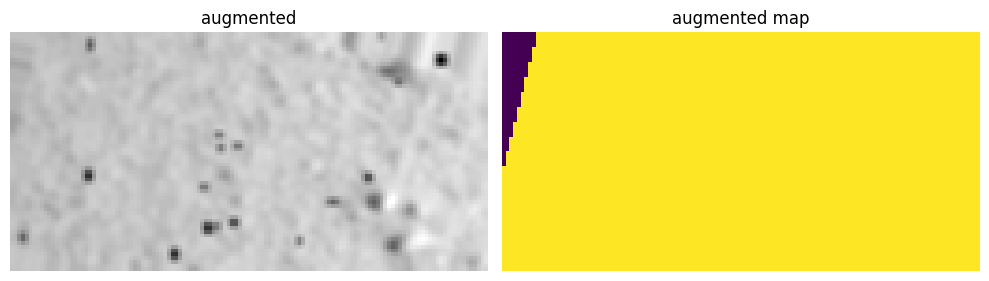

Sample 9:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:0.0 0.0 0.0
test pixel augmented:0.0 0.0 0.0


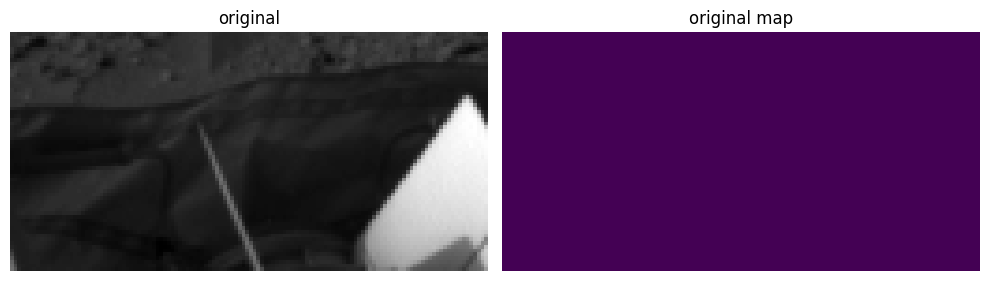

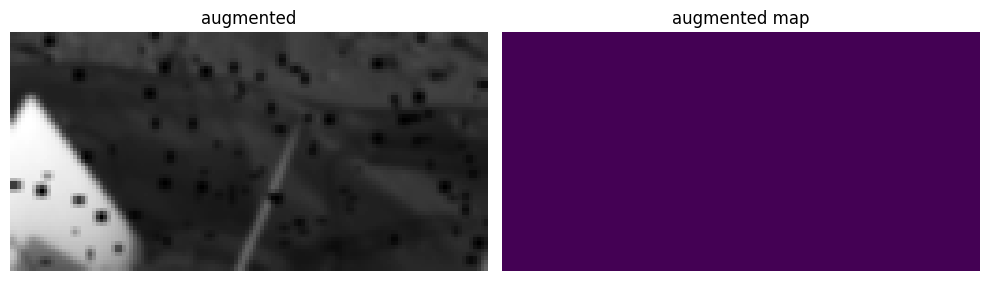

Sample 10:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 3.0 3.0
test pixel augmented:3.0 3.0 3.0


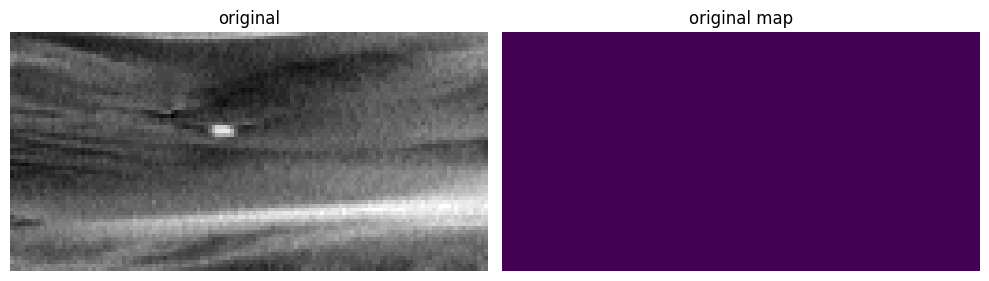

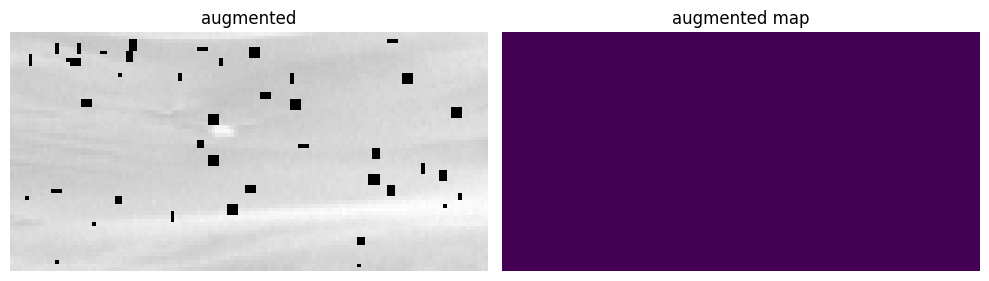

Sample 11:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 3.0 3.0
test pixel augmented:3.0 3.0 3.0


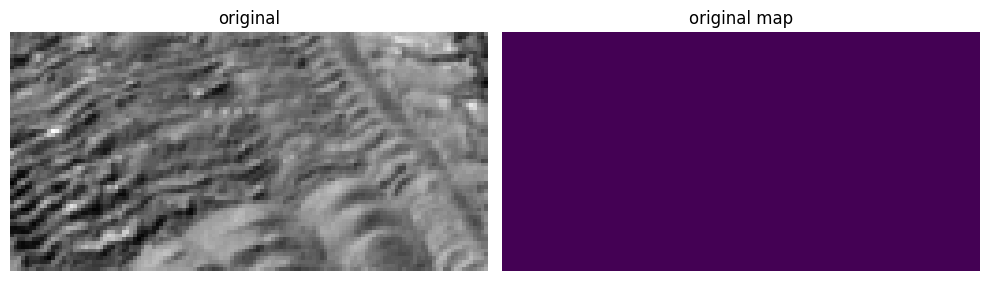

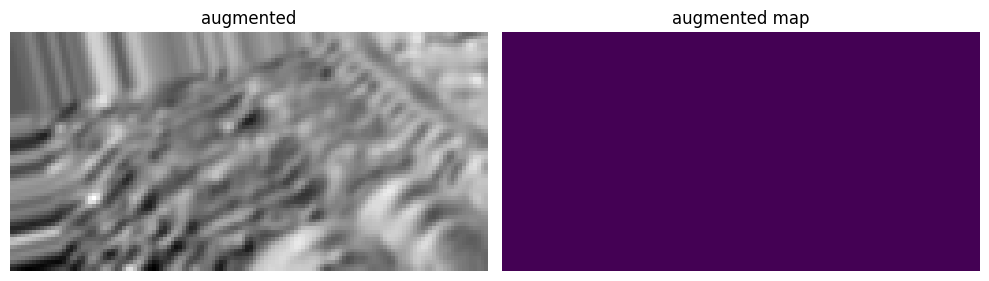

Sample 12:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


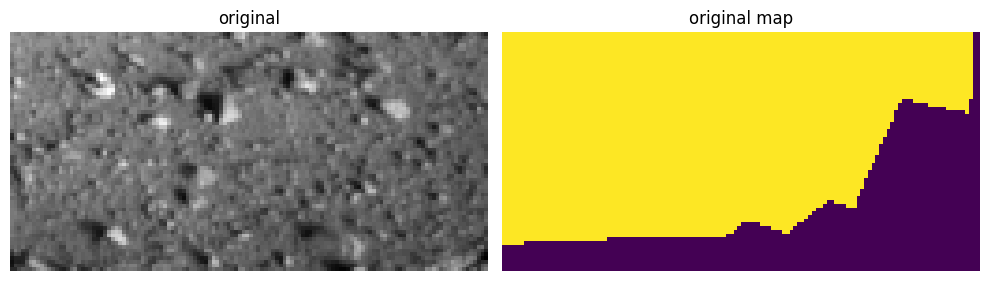

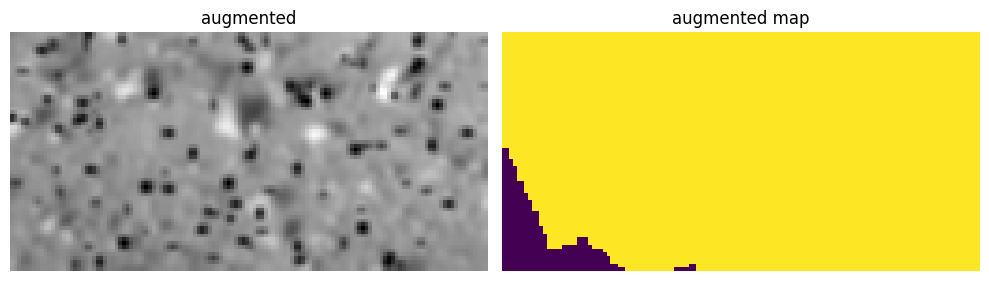

Sample 13:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:2.0 2.0 2.0
test pixel augmented:2.0 2.0 2.0


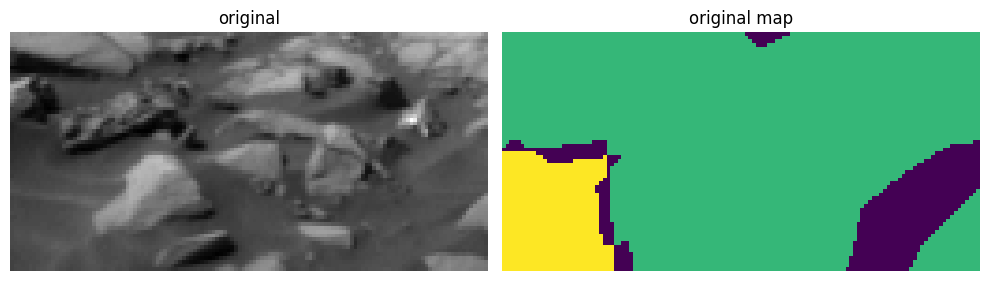

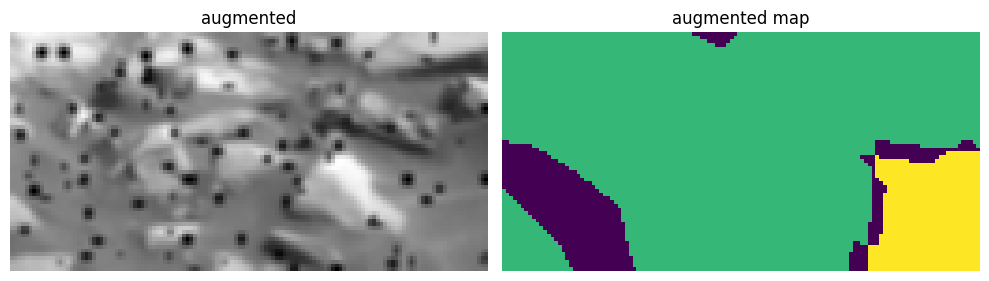

Sample 14:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:0.0 0.0 3.0
test pixel augmented:0.0 0.0 0.0


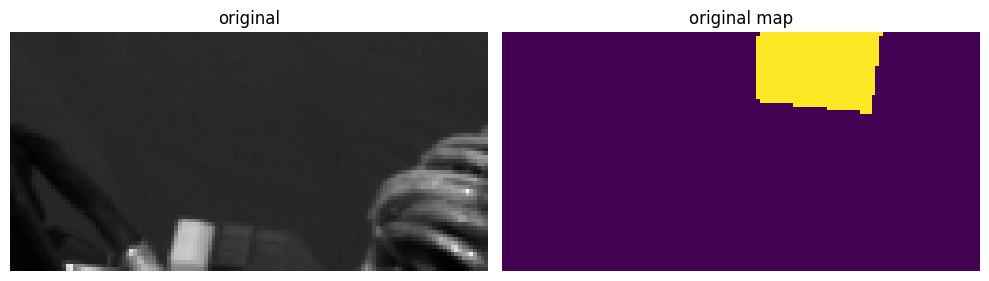

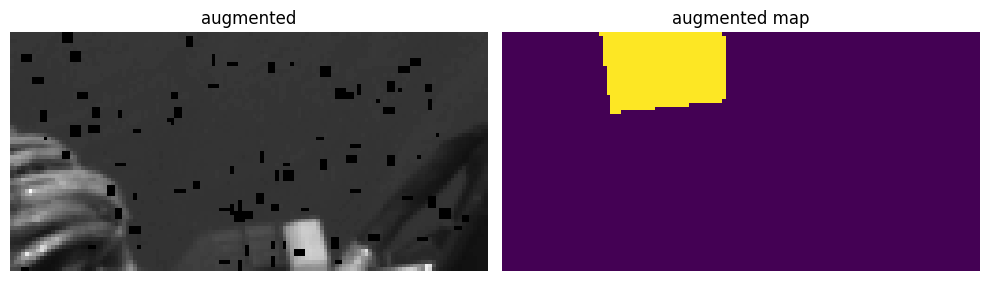

Sample 15:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:0.0 0.0 1.0
test pixel augmented:1.0 1.0 0.0


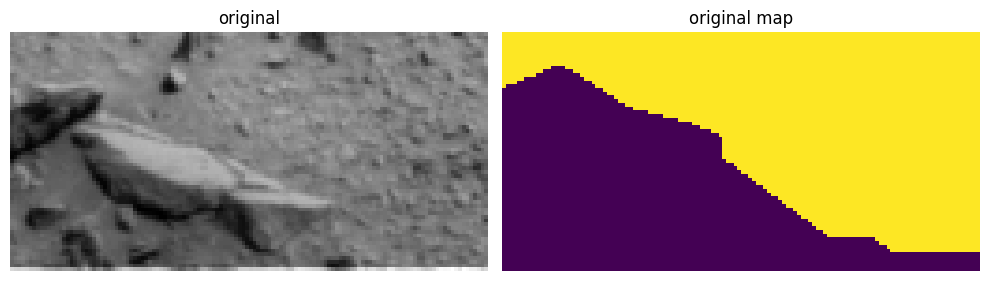

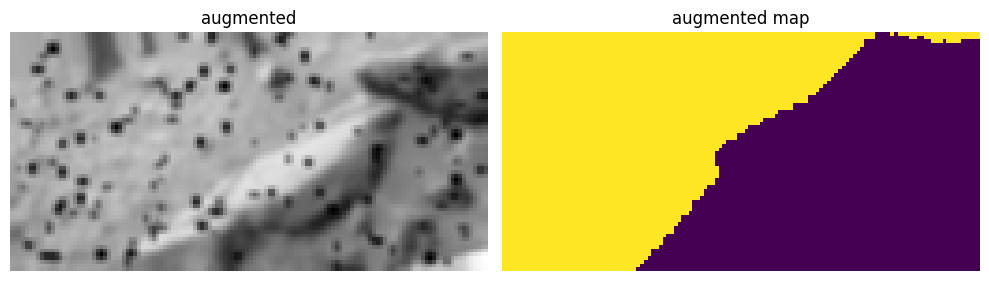

Sample 16:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:2.0 2.0 2.0
test pixel augmented:2.0 2.0 2.0


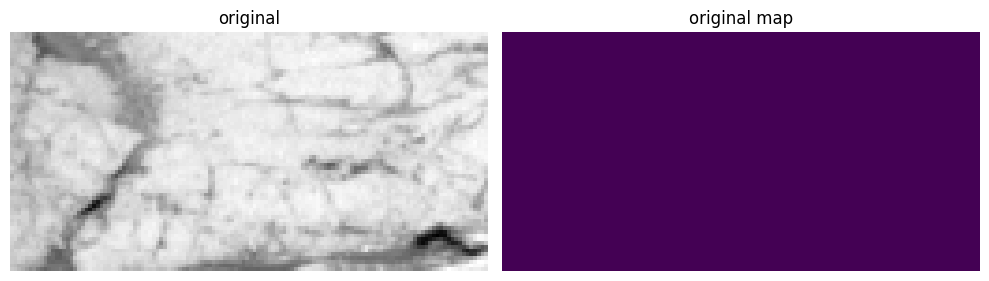

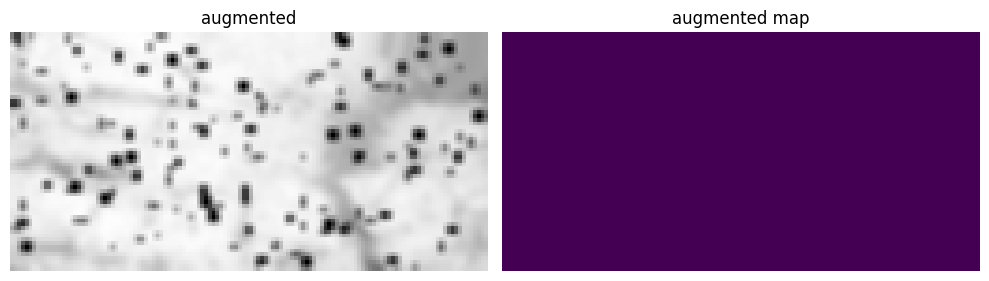

Sample 17:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


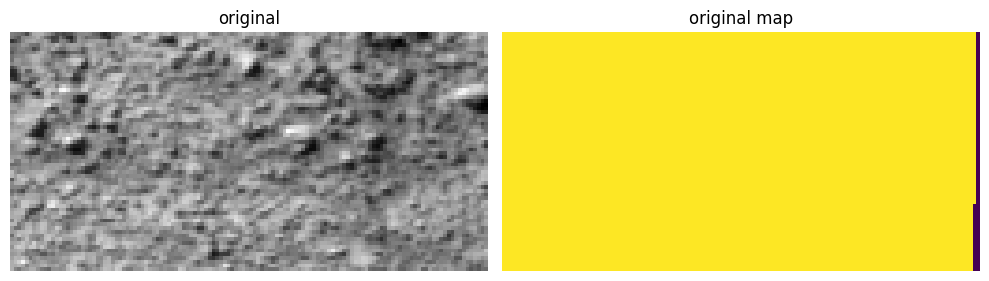

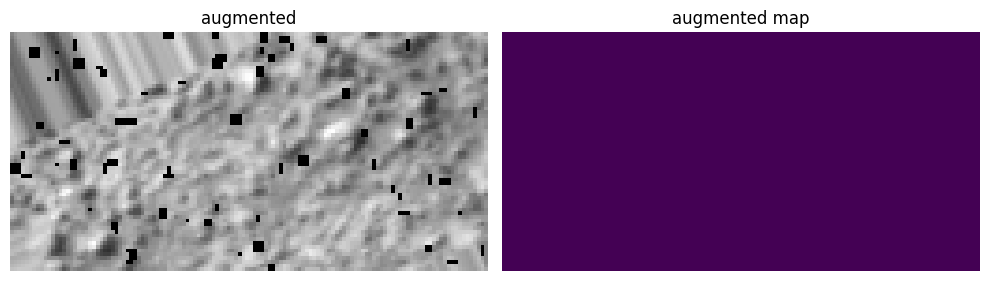

Sample 18:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 3.0 3.0
test pixel augmented:3.0 3.0 3.0


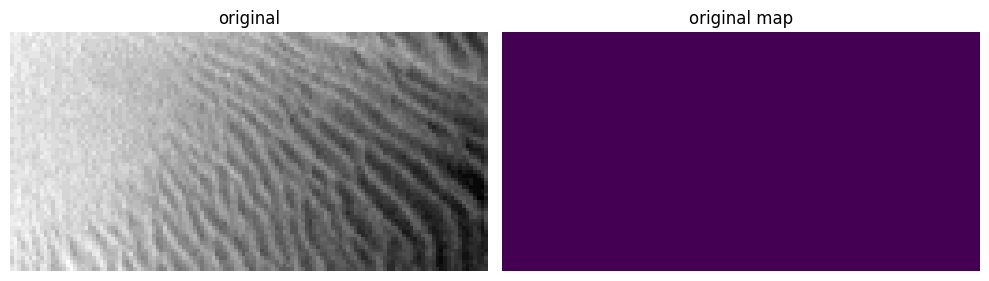

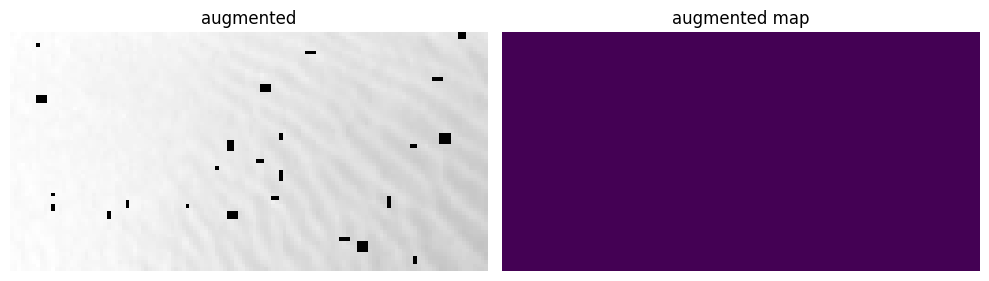

Sample 19:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 3.0 3.0
test pixel augmented:3.0 3.0 3.0


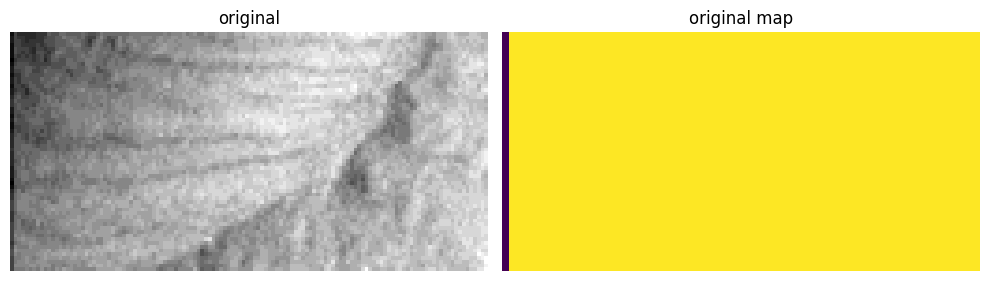

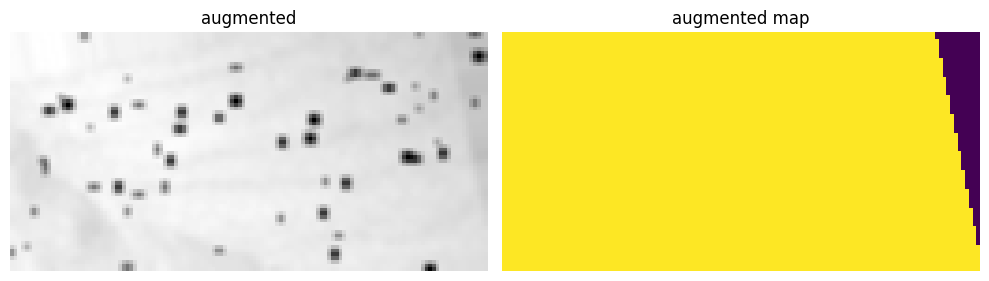

Sample 20:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


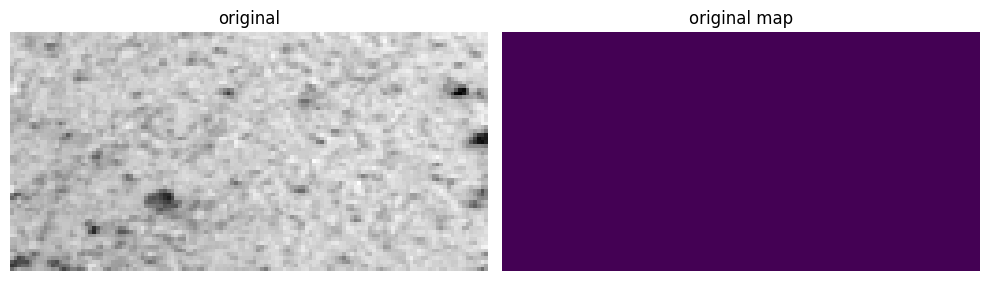

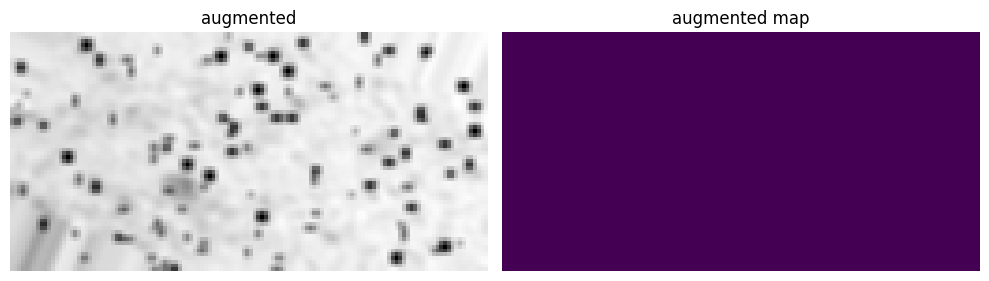

Sample 21:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:0.0 0.0 1.0
test pixel augmented:0.0 1.0 0.0


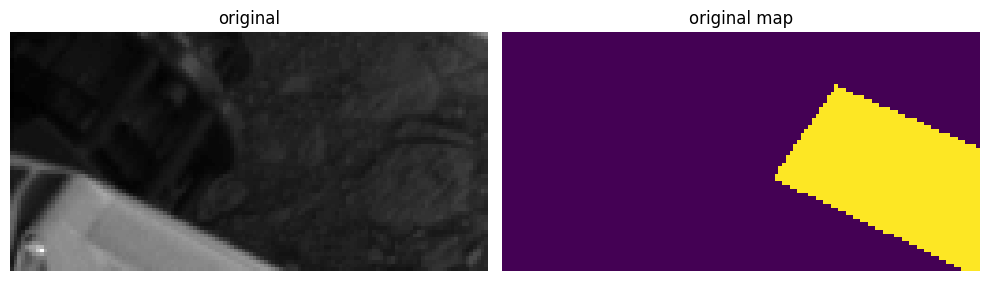

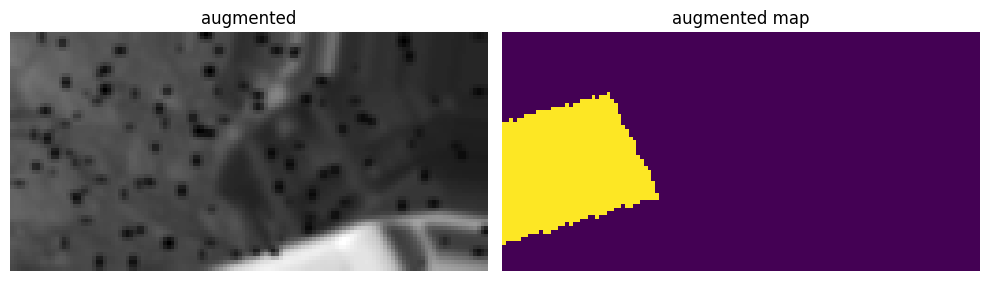

Sample 22:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:2.0 2.0 2.0
test pixel augmented:2.0 2.0 2.0


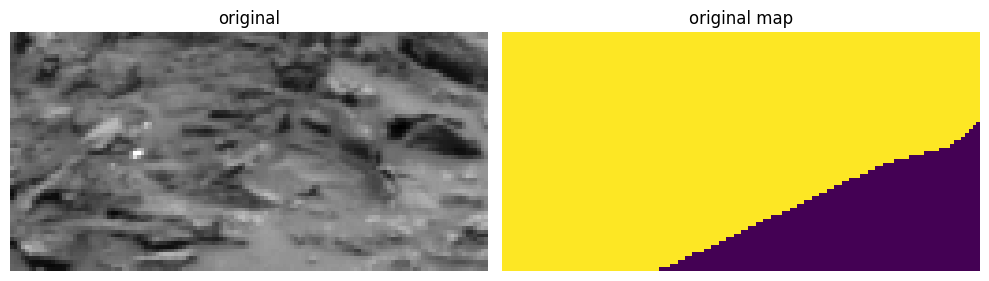

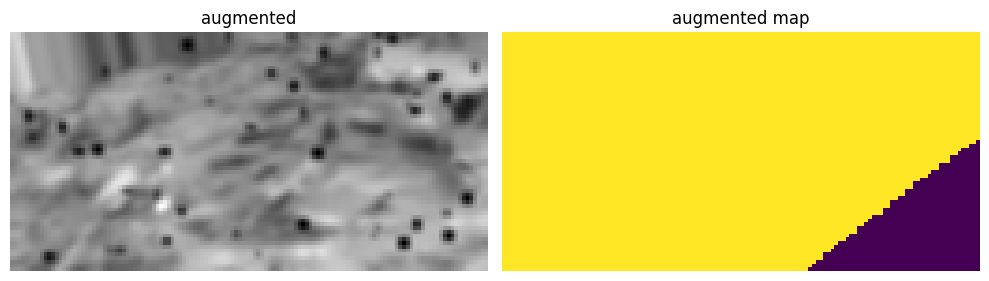

Sample 23:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


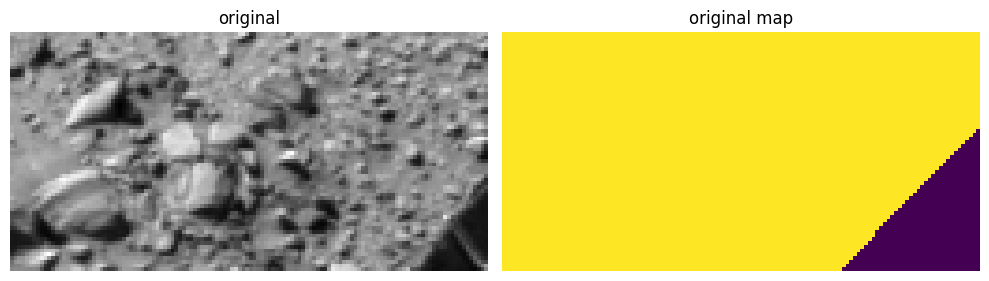

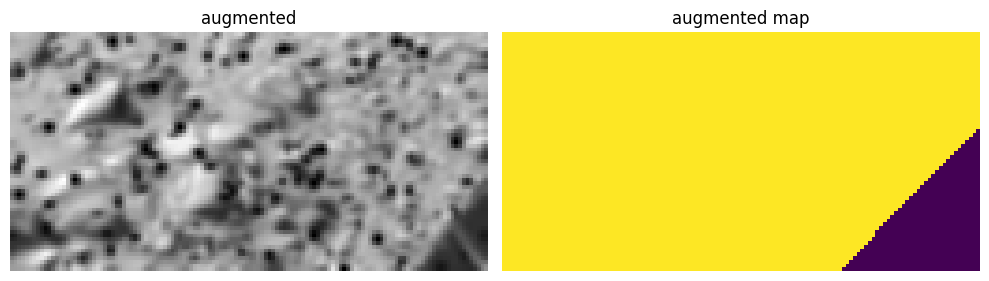

Sample 24:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:2.0 3.0 0.0
test pixel augmented:0.0 0.0 2.0


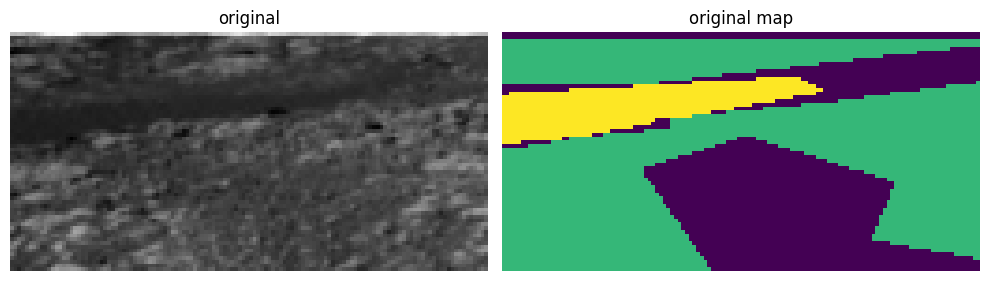

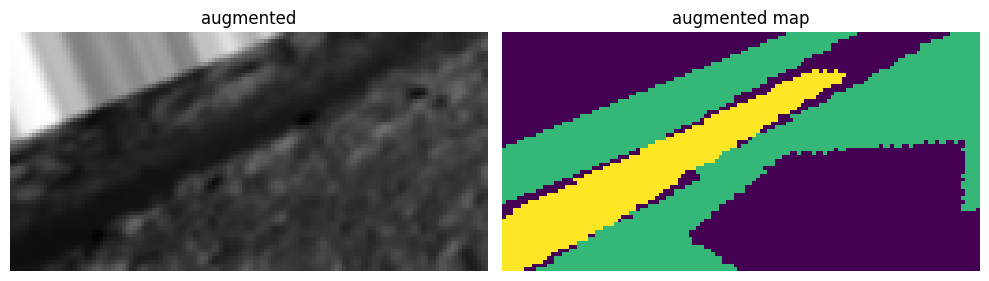

Sample 25:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 3.0 3.0
test pixel augmented:3.0 3.0 2.0


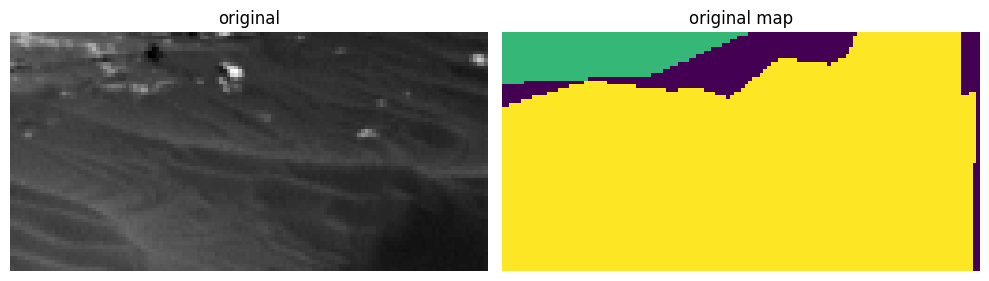

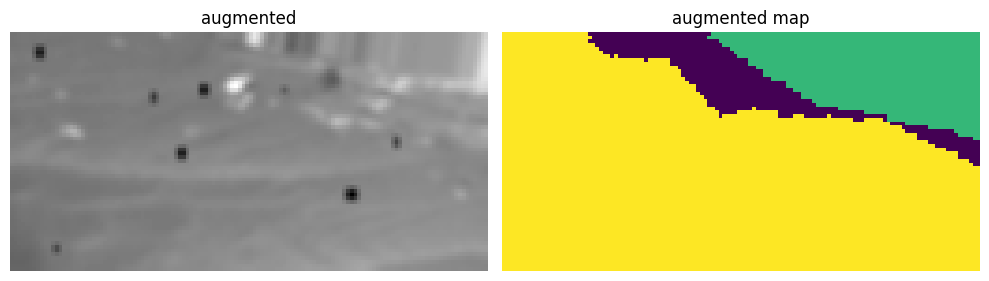

Sample 26:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:0.0 0.0 0.0
test pixel augmented:0.0 0.0 0.0


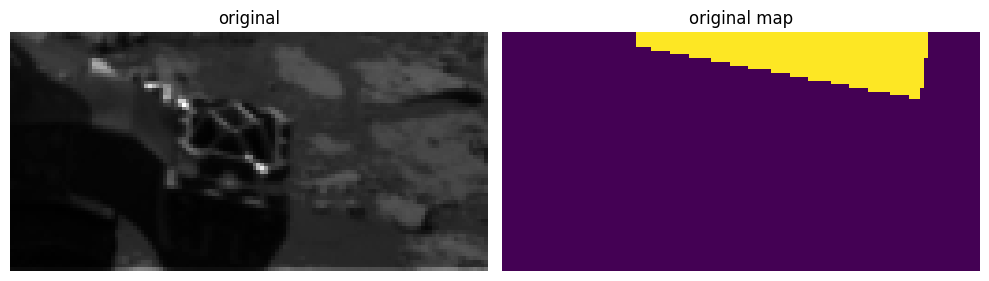

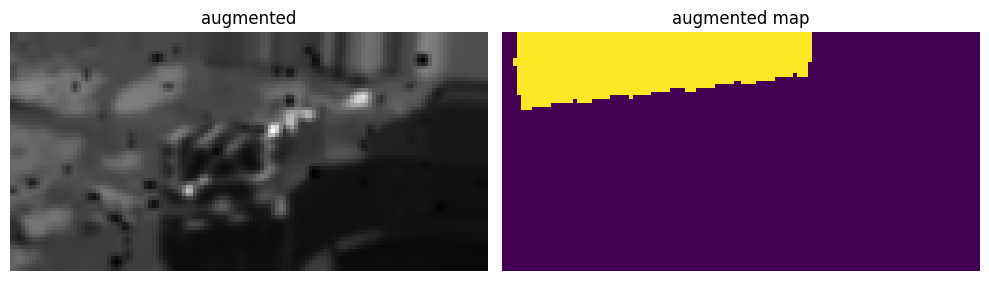

Sample 27:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


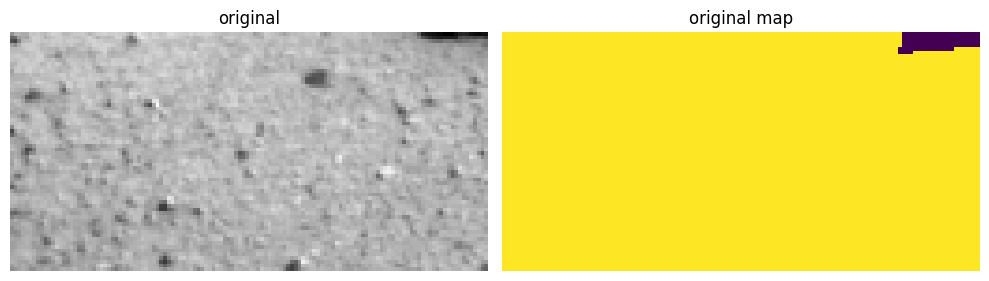

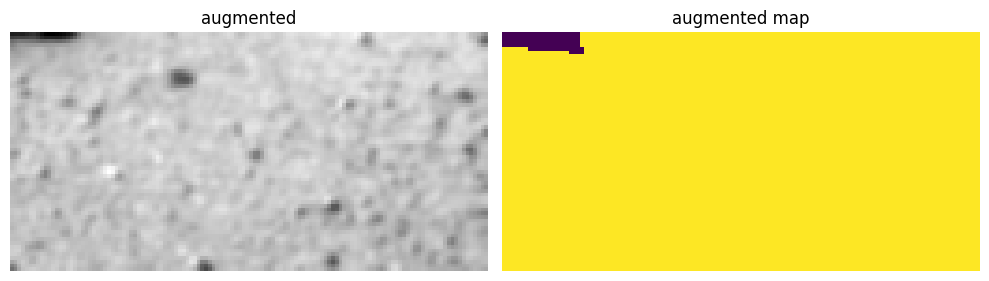

Sample 28:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:0.0 0.0 0.0
test pixel augmented:0.0 0.0 0.0


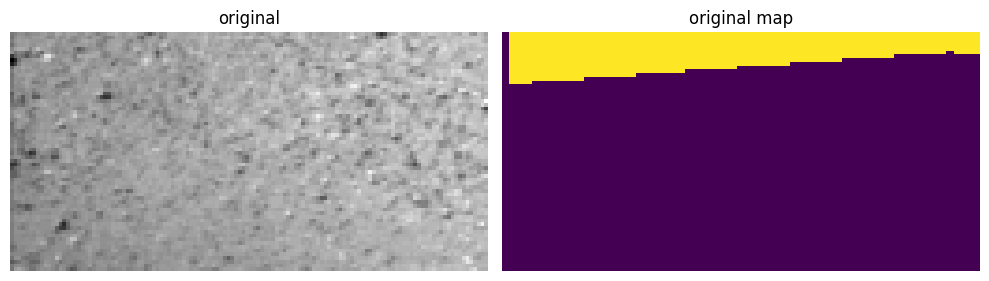

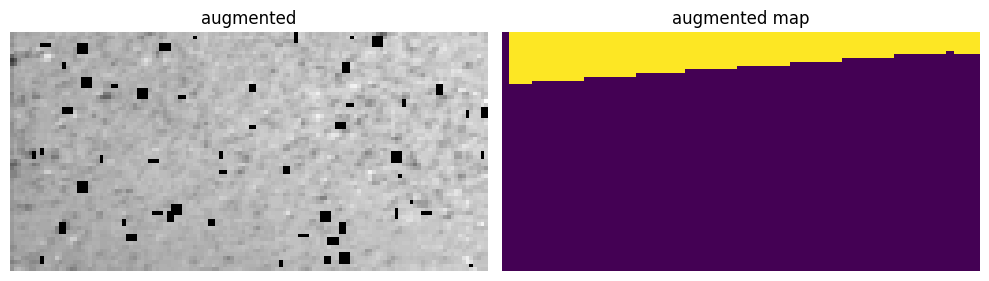

Sample 29:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 3.0 3.0
test pixel augmented:3.0 3.0 3.0


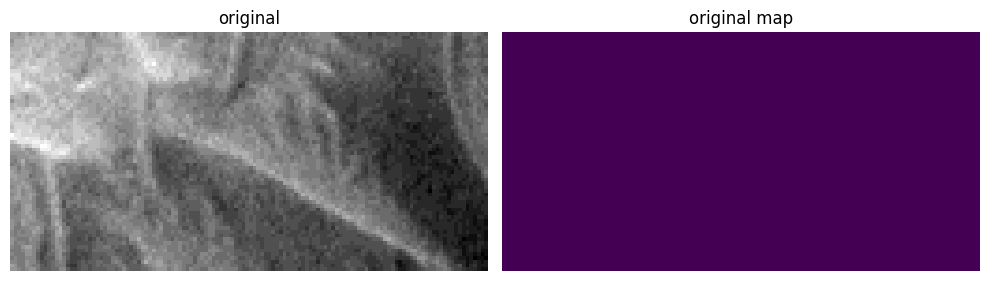

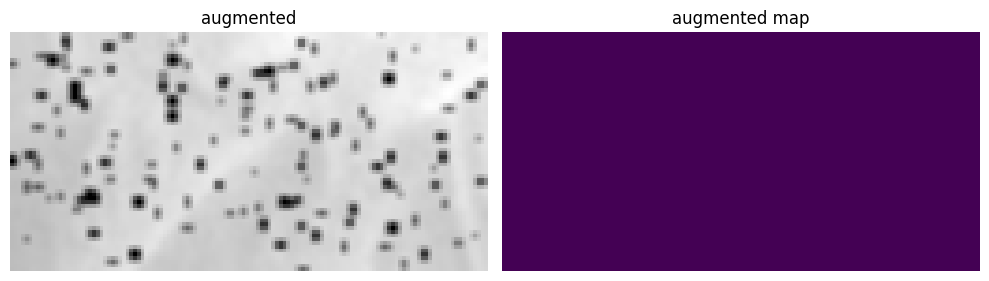

Sample 30:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 3.0 3.0
test pixel augmented:3.0 3.0 3.0


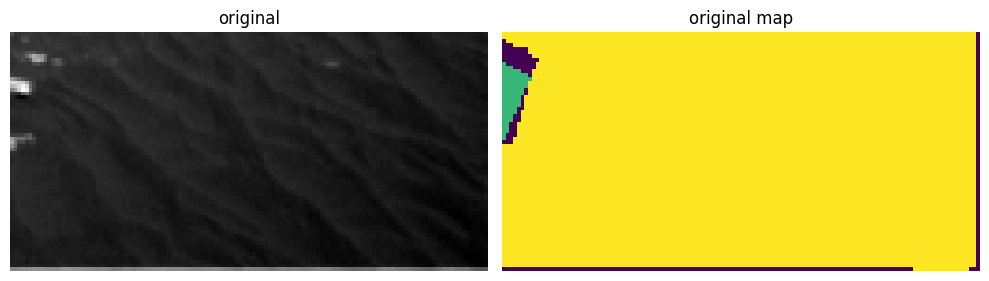

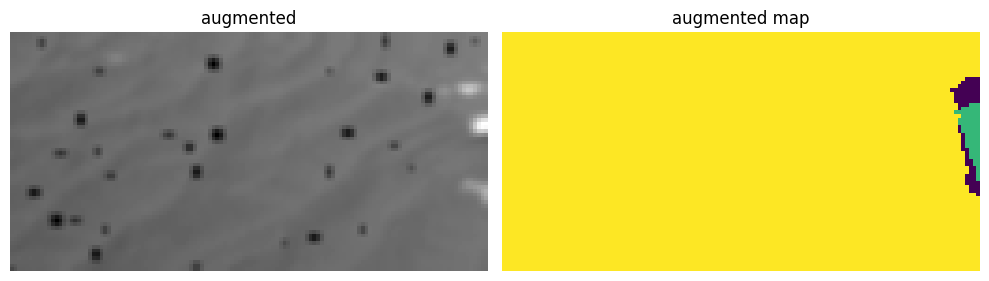

Sample 31:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 0.0 1.0
test pixel augmented:1.0 1.0 0.0


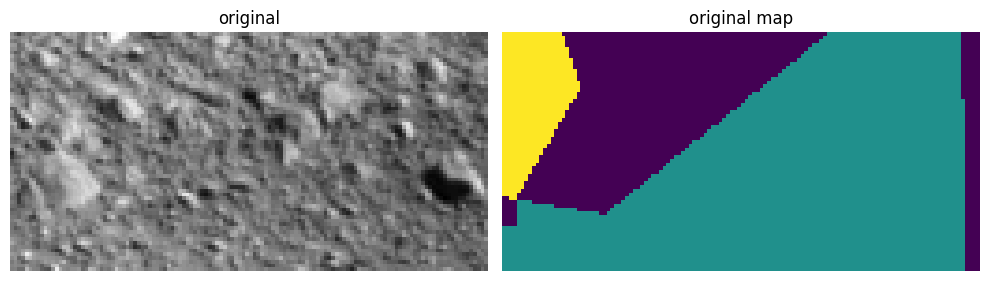

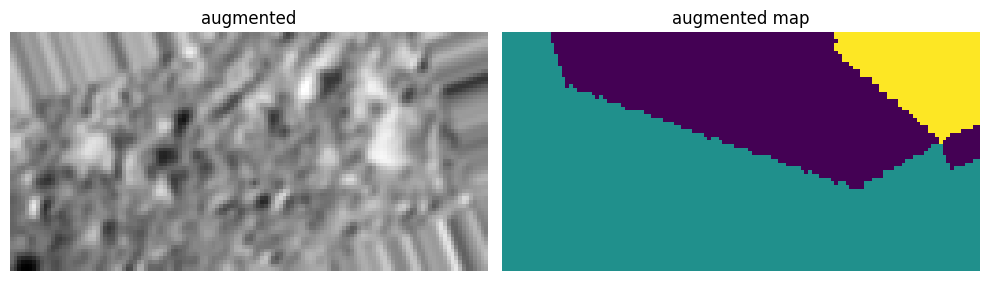

Sample 32:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:0.0 0.0 3.0
test pixel augmented:3.0 3.0 0.0


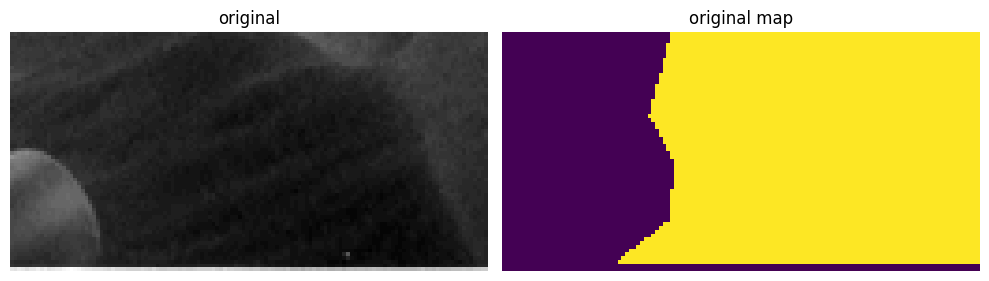

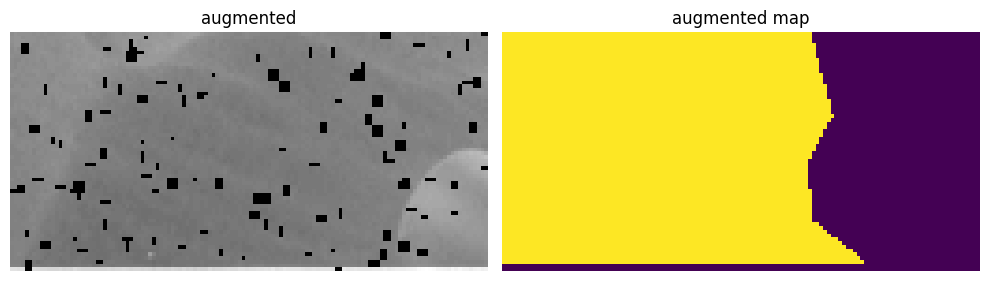

Sample 33:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


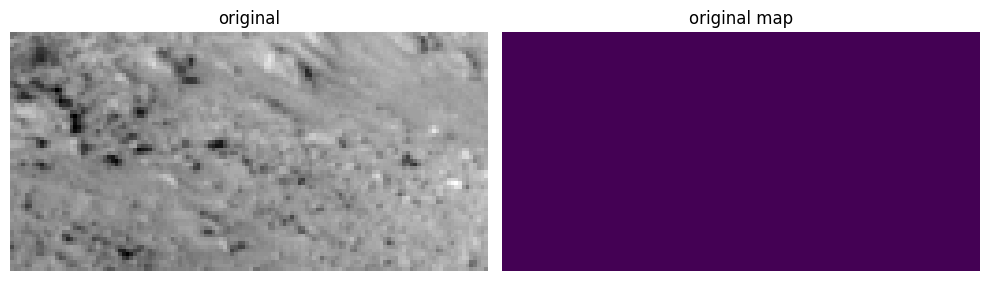

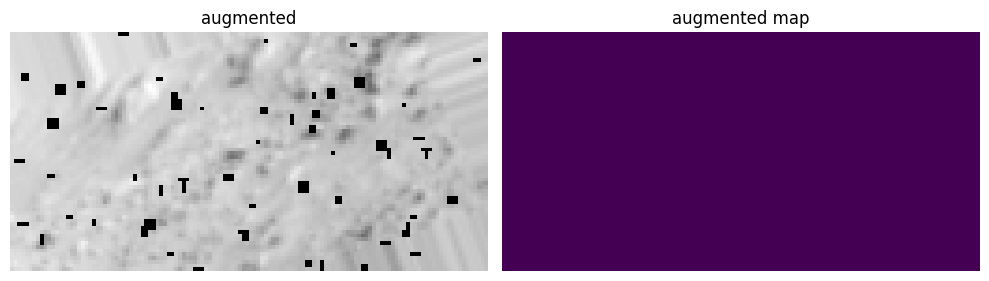

Sample 34:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:2.0 3.0 3.0
test pixel augmented:3.0 3.0 3.0


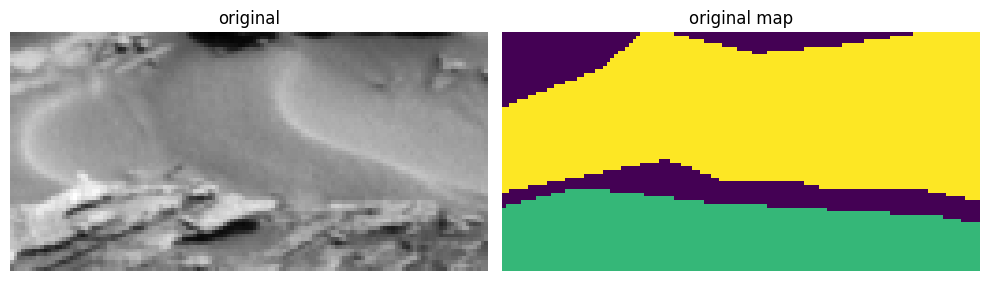

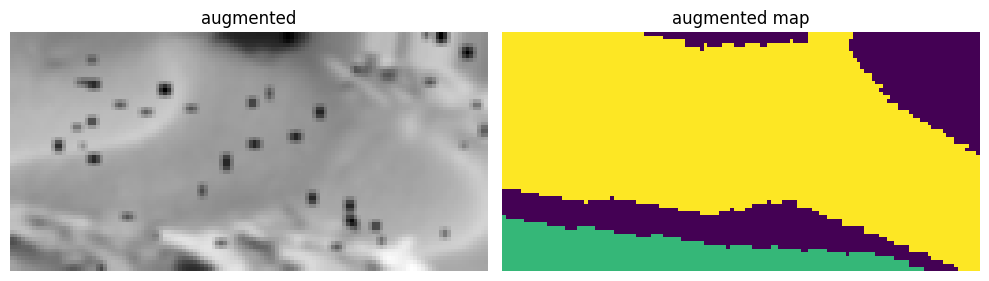

Sample 35:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 3.0 3.0
test pixel augmented:3.0 3.0 3.0


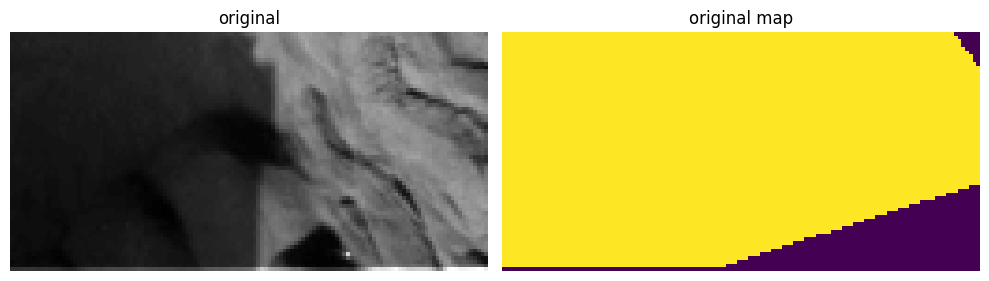

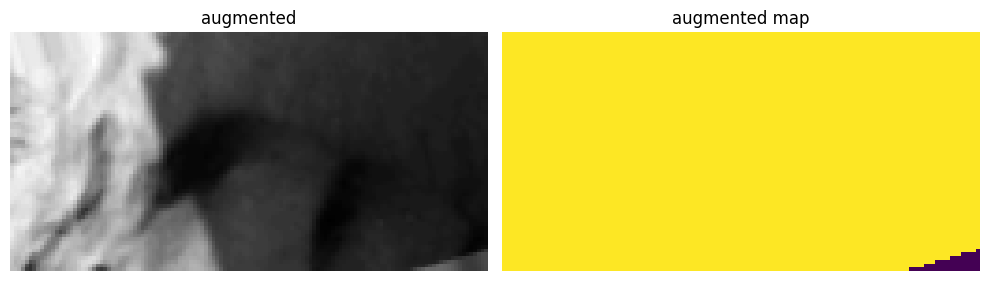

Sample 36:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 0.0 0.0
test pixel augmented:0.0 0.0 0.0


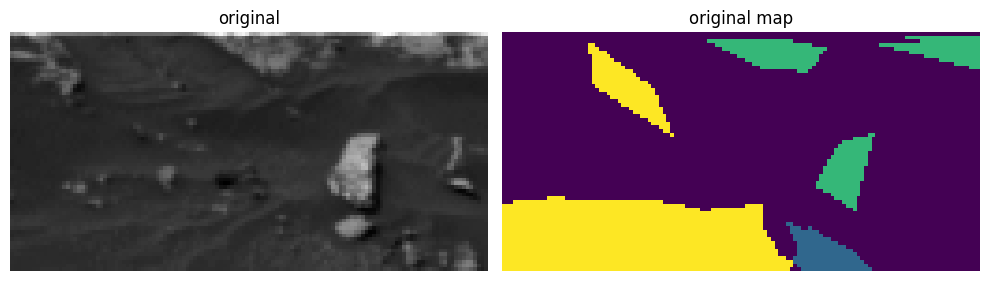

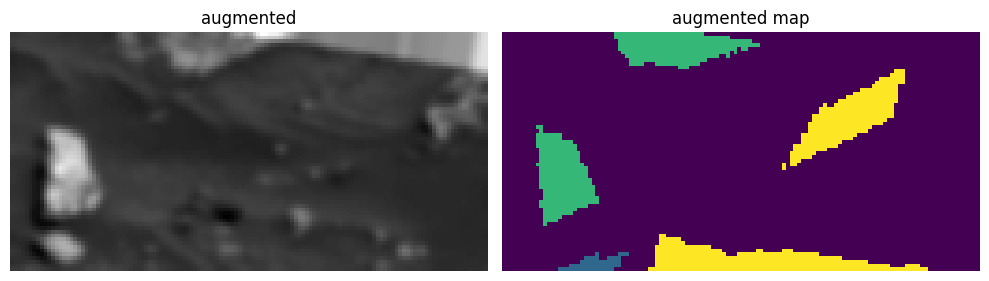

Sample 37:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 3.0
test pixel augmented:1.0 1.0 1.0


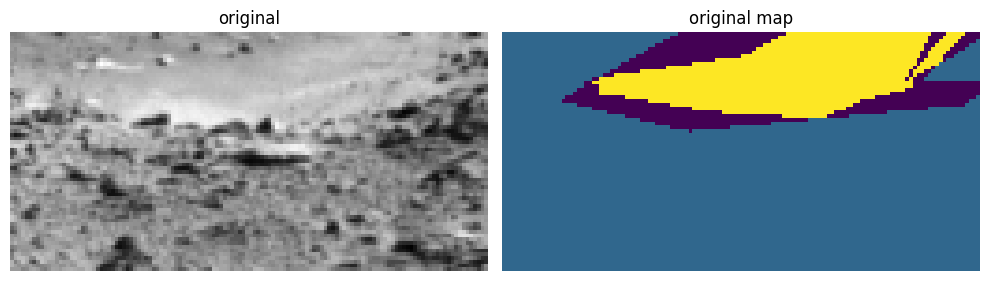

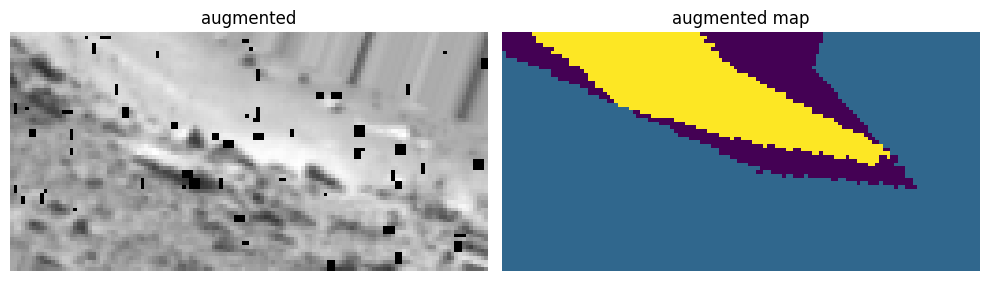

Sample 38:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:0.0 0.0 0.0
test pixel augmented:0.0 0.0 0.0


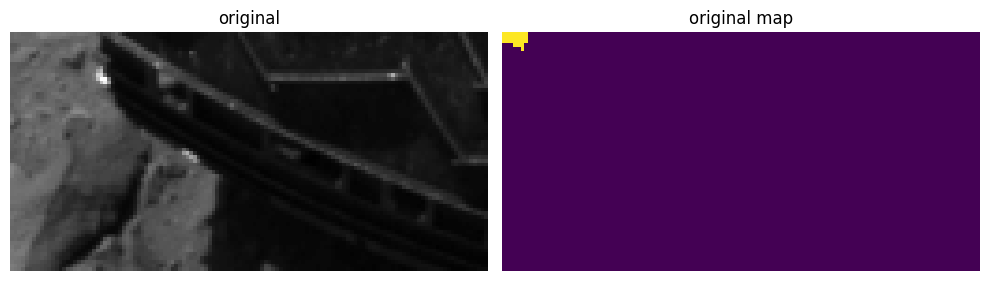

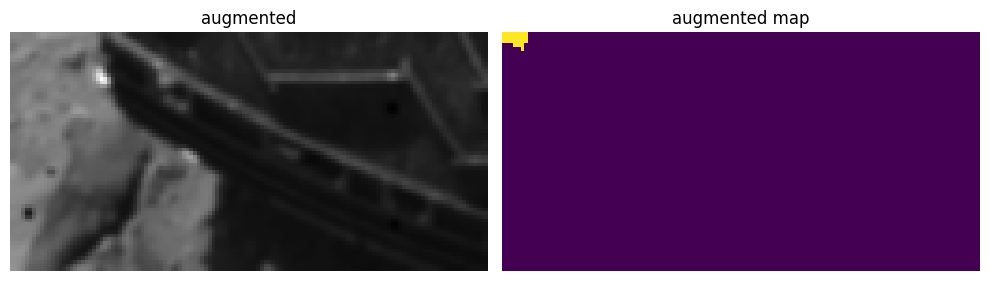

Sample 39:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 3.0 3.0
test pixel augmented:3.0 3.0 3.0


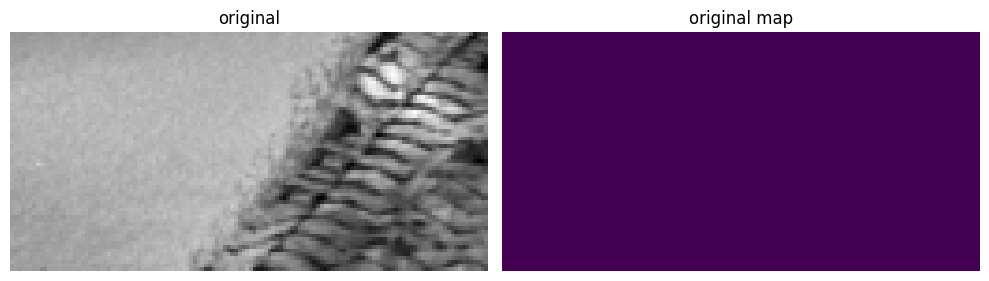

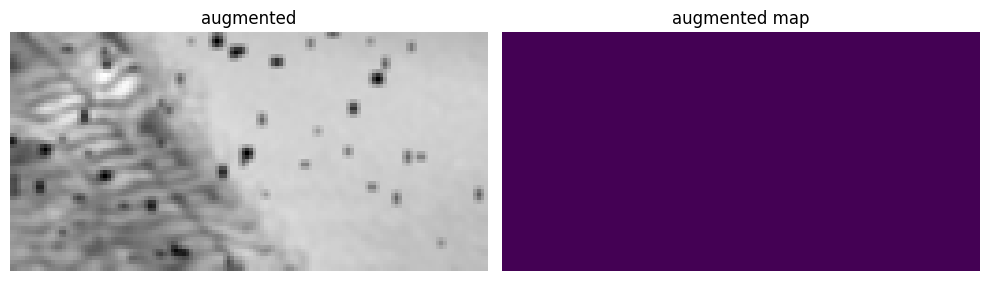

Sample 40:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


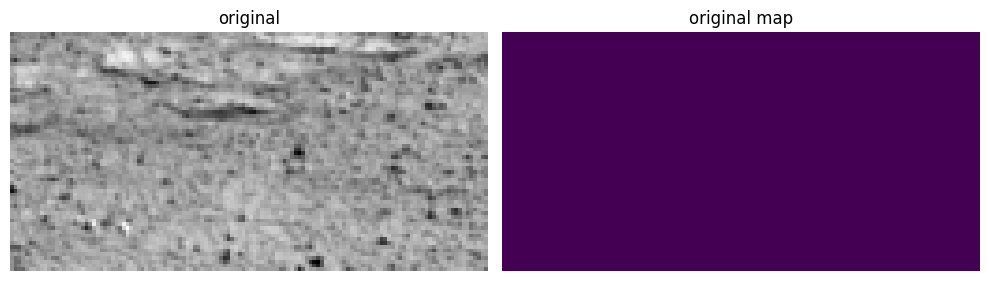

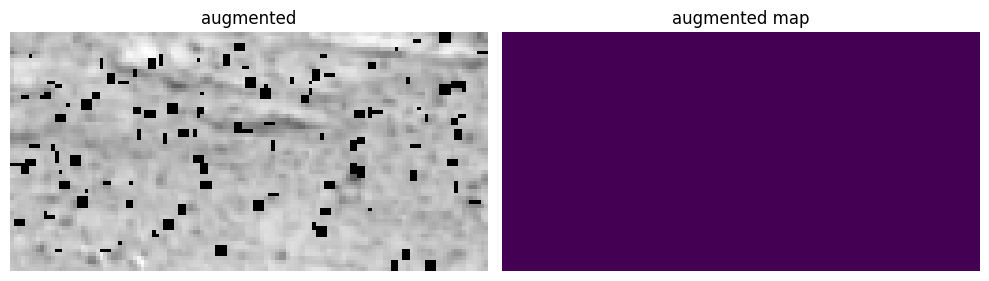

Sample 41:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 0.0 2.0
test pixel augmented:2.0 2.0 0.0


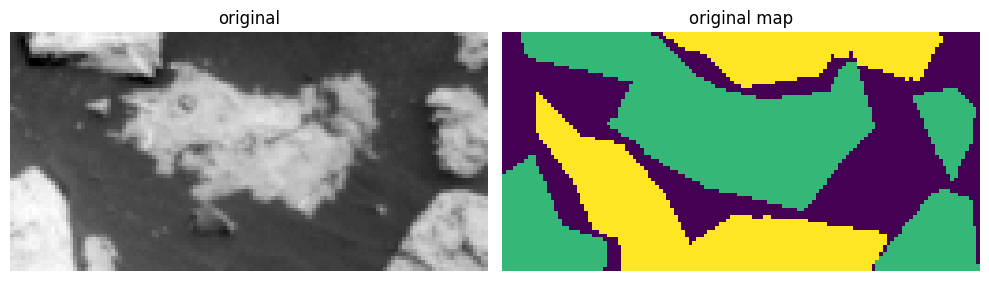

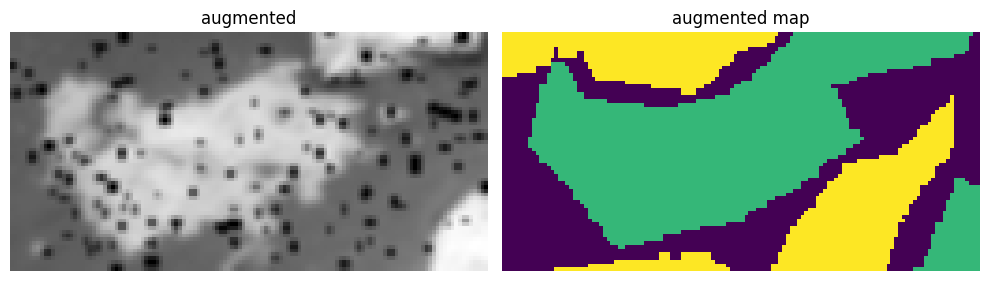

Sample 42:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:0.0 3.0 0.0
test pixel augmented:0.0 0.0 3.0


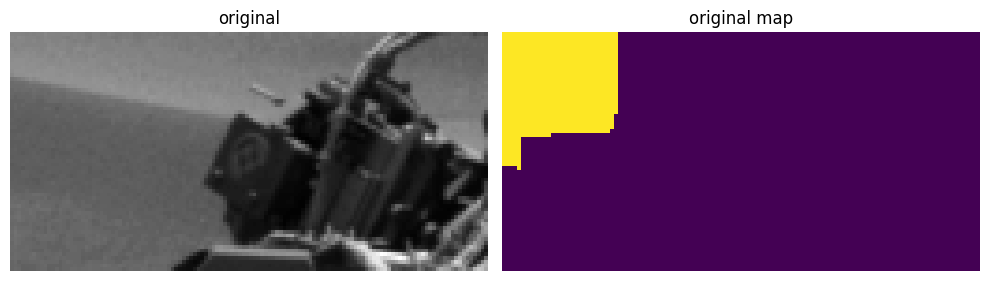

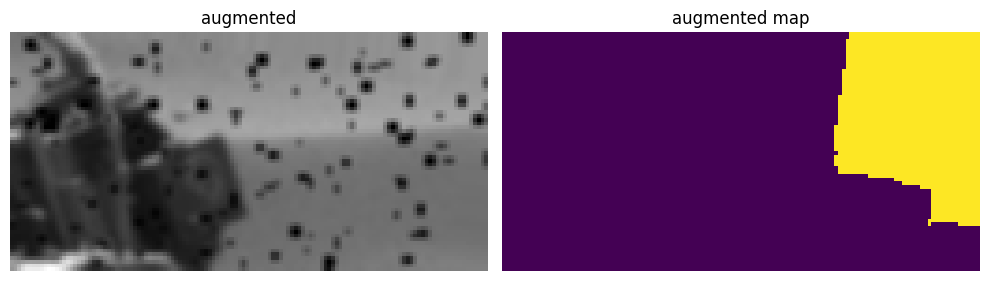

Sample 43:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:2.0 2.0 0.0
test pixel augmented:0.0 0.0 0.0


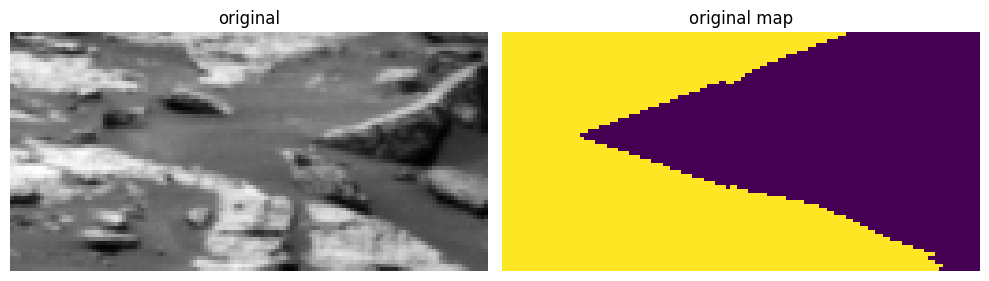

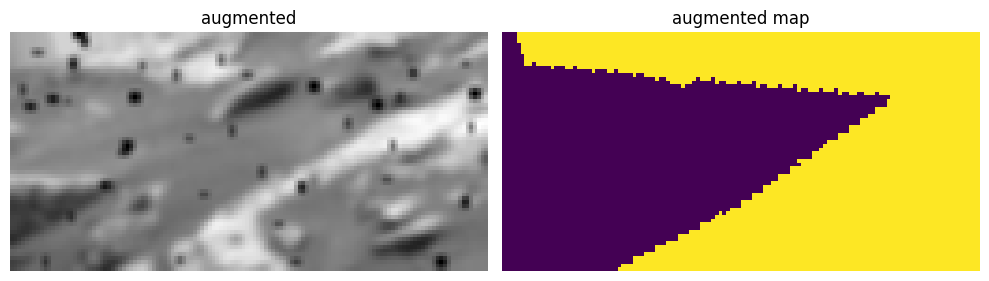

Sample 44:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


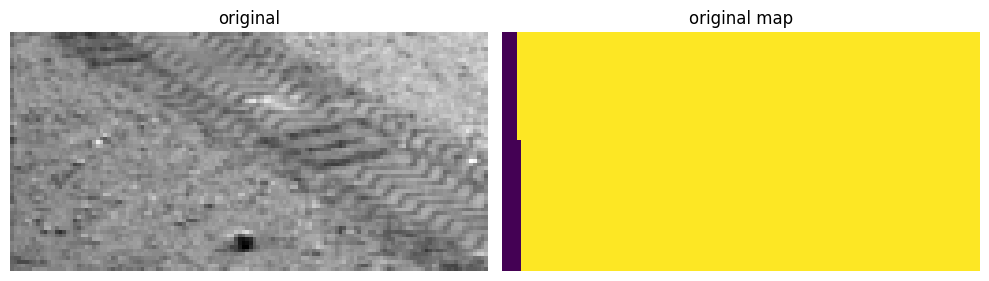

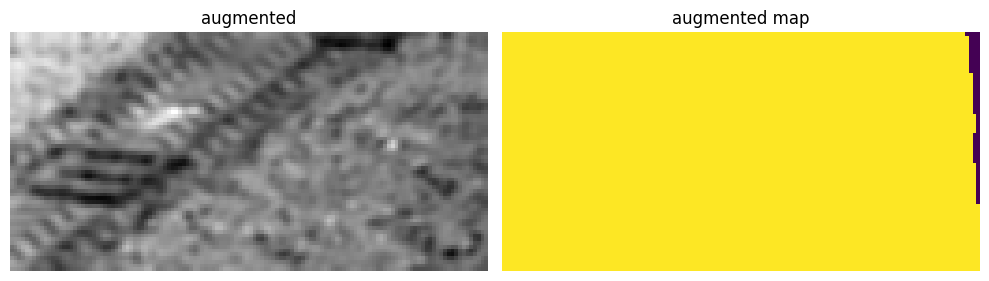

Sample 45:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


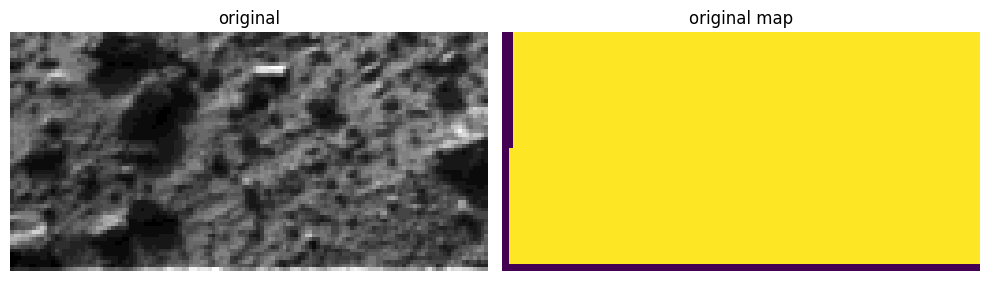

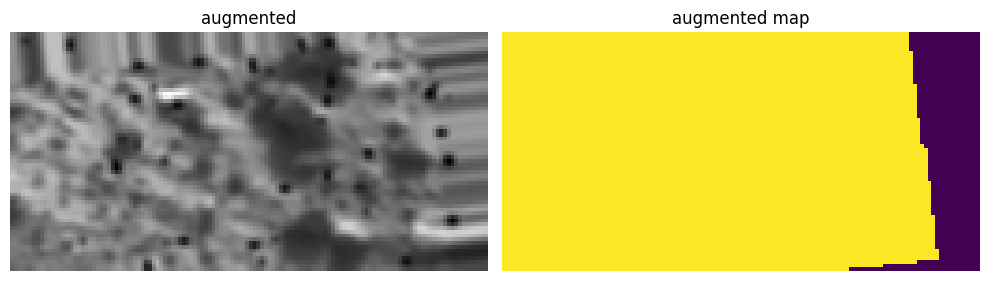

Sample 46:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:0.0 0.0 2.0
test pixel augmented:2.0 2.0 0.0


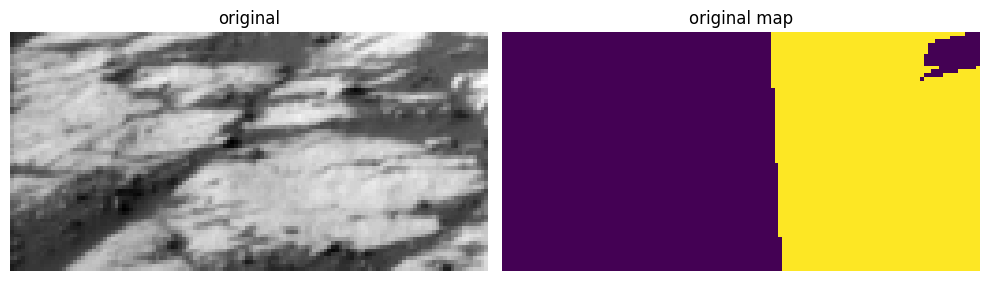

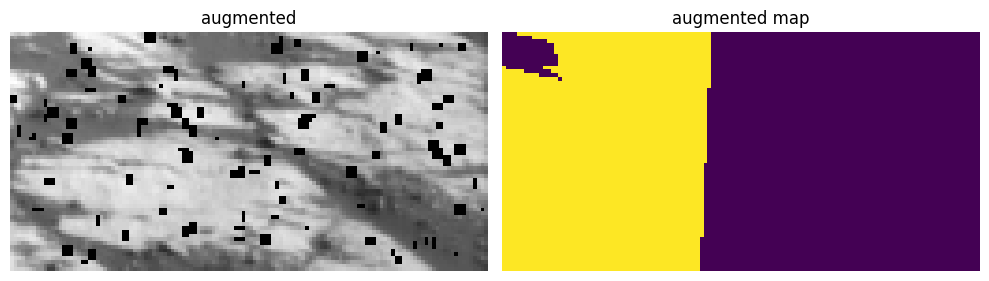

Sample 47:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 3.0 3.0
test pixel augmented:3.0 3.0 3.0


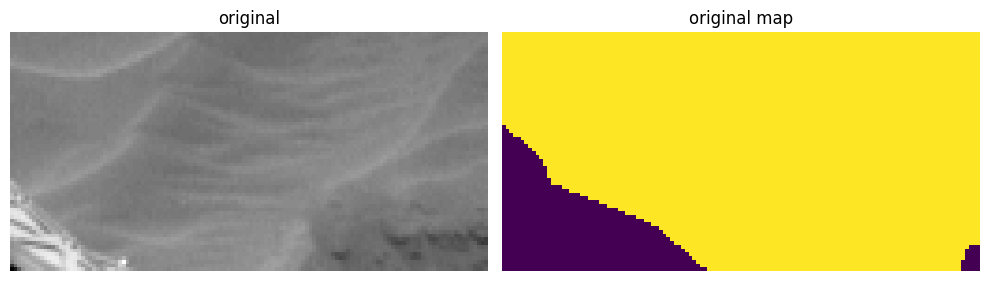

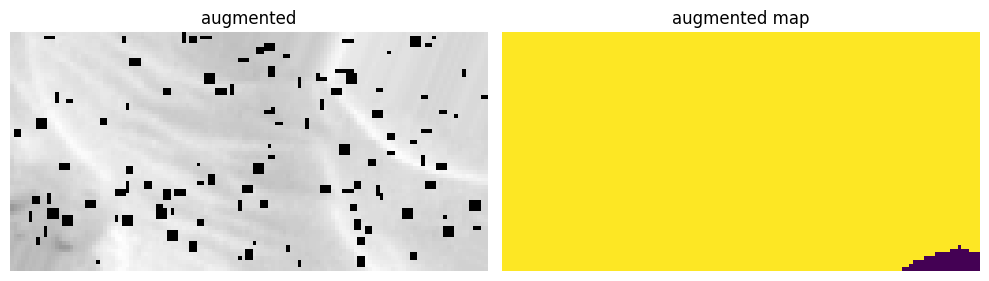

Sample 48:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 3.0 3.0
test pixel augmented:3.0 3.0 3.0


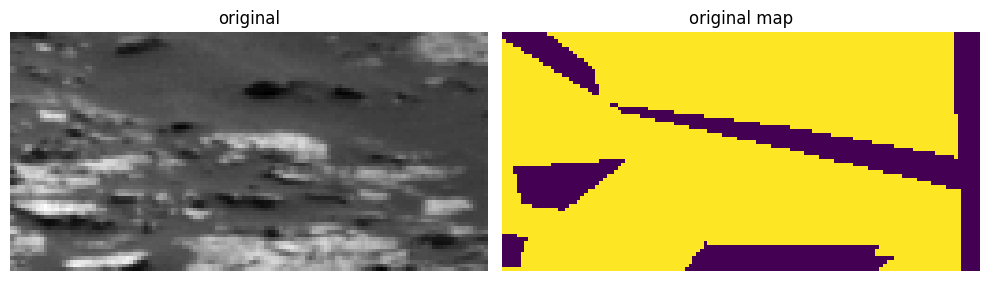

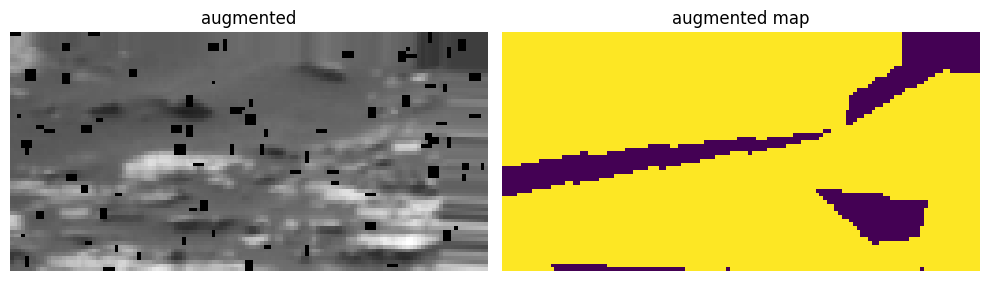

Sample 49:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:1.0 1.0 1.0
test pixel augmented:1.0 1.0 1.0


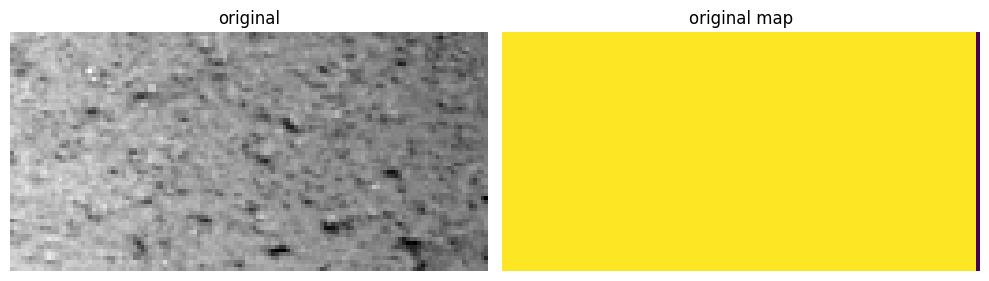

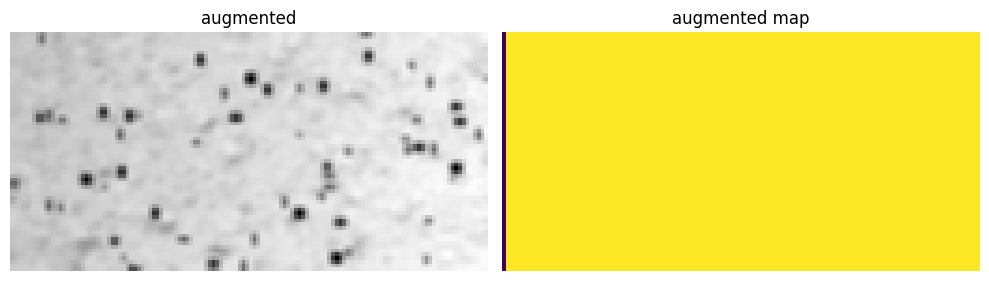

Sample 50:
Image original shape: (64, 128, 1)
Label original shape: (64, 128)
Image shape: (64, 128, 1)
Label shape: (64, 128)
test pixel:3.0 3.0 0.0
test pixel augmented:3.0 0.0 0.0


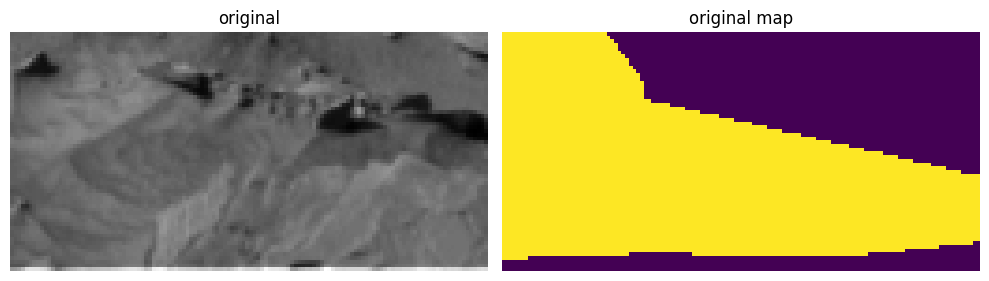

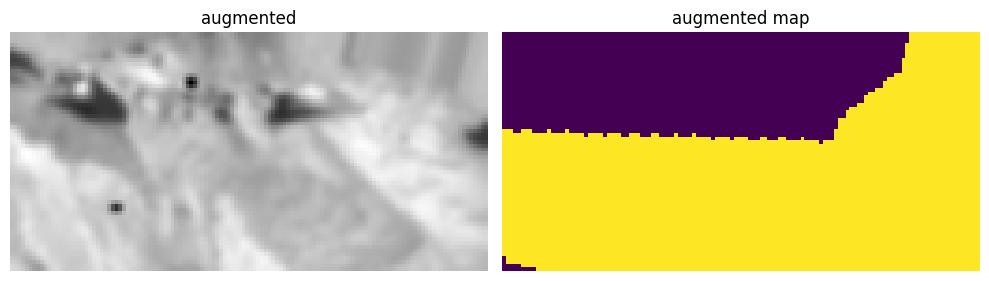

In [33]:
#display image
max_img = 50
for i, (img, label) in enumerate(zip(augmented_dataset[0], augmented_dataset[1])):
  if i >= max_img:  # Limita a massimo 50 iterazioni
        break

  print(f"Sample {i + 1}:")
  print(f"Image original shape: {X_train[i].shape}")
  print(f"Label original shape: {y_train[i].shape}")
  print(f"Image shape: {img.shape}")
  print(f"Label shape: {label.shape}")

  print("test pixel:" + str(y_train[i][45][40]) + " " + str(y_train[i][20][18]) + " " + str(y_train[i][16][91]))
  print("test pixel augmented:" + str(label[45][40]) + " " + str(label[20][18]) + " " + str(label[16][91]))
  display_aug(X_train[i], y_train[i], title="original")
  display_aug(img, label, title="augmented")

In [ ]:
print("x train len: " + str(len(X_train)) + " y train len:" + str(len(y_train)))
print("shapes: " + str(X_train.shape) + " " + str(y_train.shape))
merged_x_train, merged_y_train = merge_dataset(X_train, y_train, augmented_dataset[0], augmented_dataset[1], remove_duplicates)
print("x train len augmented: " + str(len(merged_x_train)) + " y train len augmented: " + str(len(merged_y_train)))
print("augmented shapes: " + str(merged_x_train.shape) + " " + str(merged_y_train.shape))


train_dataset = tf.data.Dataset.from_tensor_slices((merged_x_train, merged_y_train))

# Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE)

x train len: 2254 y train len:2254
shapes: (2254, 64, 128, 1) (2254, 64, 128)
x train len augmented: 4508 y train len augmented: 4508
augmented shapes: (4508, 64, 128, 1) (4508, 64, 128)


### application (n iteration)

In [54]:


if len(augmentation_probability) != n_iterations:
  raise ValueError("The number of augmentation probabilities must be equal to the number of iterations.")


merged_x_train = X_train
merged_y_train = y_train
print("x train original len: " + str(len(merged_x_train)) + " y train original len: " + str(len(merged_y_train)))

for i in range(n_iterations):
  augmented_dataset = apply_augmentation_to_dataset(X_train, y_train, augmentation_probability[i])

  merged_x_train, merged_y_train = merge_dataset(merged_x_train, merged_y_train, augmented_dataset[0], augmented_dataset[1], remove_duplicates_flag=remove_duplicates)
  print("x train len augmented: " + str(len(merged_x_train)) + " y train len augmented: " + str(len(merged_y_train)))

train_dataset = tf.data.Dataset.from_tensor_slices((merged_x_train, merged_y_train))
train_dataset = train_dataset.batch(BATCH_SIZE)

x train original len: 2254 y train original len: 2254
Number of duplicates generated from augmentation:  26
x train len augmented: 4482 y train len augmented: 4482
Number of duplicates generated from augmentation:  36
x train len augmented: 6700 y train len augmented: 6700
Number of duplicates generated from augmentation:  30
x train len augmented: 8924 y train len augmented: 8924


## Augmentations

In [ ]:
# Cutmix v1 (this does not work)
cutMixLayer = tfkcvl.CutMix()

def applyCutMix(images):
  # create a dictionary with the image and label
  data = {'images': images}
  # cast labels to float32
  data = cutMixLayer(data, training=True)
  # return the modified image and label
  return data['images']

In [ ]:
def display_aug(img, label, title=" "):

  fig, axes = plt.subplots(1, 2, figsize=(10, 20))
  ax1, ax2 = axes[0], axes[1]  # Corrected line
  ax1.imshow(img, cmap="gray")
  ax2.imshow(label)

  # Add titles to the subplots
  ax1.set_title(f"{title}")
  ax2.set_title(f"{title} map")  # Set title from the input argument

  ax1.axis("off")
  ax2.axis("off")
  plt.tight_layout()
  plt.show()

# Function to create the augmentation pipeline with the seed for each layer
def create_augmentation_pipeline(seed=None):
    return [
        tfkl.RandomFlip(seed=seed),  #singolarmente funziona correttamente
        # tfkl.RandomRotation(factor=0.3, seed=seed), #singolarmente funziona correttamente
        # tfkl.RandomTranslation(-0.3, 0.3, seed=seed), #sembra non funzionare
        # tfkl.RandomContrast(factor=0.2, seed=seed),            # Random contrast
        tf.keras.layers.RandomBrightness(factor=0.2, value_range=(0, 1), seed=seed), # Random brightness  # This FUCKS UP THE LABELS
        # tfkl.RandomZoom(height_factor=0.2, width_factor=0.2),  # zoom (NON USARE, CORROMPE I LABELS),
        tfkcvl.GridMask(ratio_factor=0.7, seed=seed),
        # applyCutMix,      # to make this work the implementation must be changes to use the whole dataset at once like HW1

    ]

def apply_basic_aug_2(image, label, augmentation_pipeline):
    # Expand dimensions of the label to match the image shape
    label = tf.expand_dims(label, axis=-1)  # Add a channel dimension to the label

    # Combine image and label along a new axis to apply the same augmentation
    combined = tf.stack([image, label], axis=0)

    # Apply the augmentation pipeline to the combined tensor
    augmented_combined = combined
    for layer in augmentation_pipeline:
        augmented_combined = layer(augmented_combined)

    # Separate image and label after augmentation
    augmented_img = augmented_combined[0]
    augmented_label = augmented_combined[1]

    print(f"Augmented Image shape: {augmented_img.shape}")
    print(f"Augmented Label shape: {augmented_label.shape}")

    # Return transformed image and label
    return augmented_img, augmented_label


def apply_basic_aug(image, label, augmentation_pipeline):
    # Expand dimensions of the label to match the image shape
    label = tf.expand_dims(label, axis=-1)  # Add a channel dimension to the label

    # Combine image and label along a new axis to apply the same augmentation
    combined = tf.stack([image, label], axis=2) # Shape: (64, 128, 2, 1)

    # Remove the batch dimension (also remember that batch is the first and not the last)
    combined = tf.squeeze(combined, axis=-1)  # Shape: (64, 128, 2)


    print(f"Image shape: {image.shape}")
    print(f"Label shape: {label.shape}")
    print(f"Combined shape: {combined.shape}")


    # Apply the augmentation pipeline to the combined tensor
    augmented_combined = combined
    for layer in augmentation_pipeline:
        augmented_combined = layer(augmented_combined)

    # Separate image and label after augmentation
    # Assuming `input_tensor` has shape (64, 128, 2, 1)
    augmented_img, augmented_label = tf.split(augmented_combined, num_or_size_splits=2, axis=2)

    augmented_img = tf.squeeze(augmented_img, axis=-1)  # Shape: (64, 128, 1)
    augmented_label = tf.squeeze(augmented_label, axis=-1)  # Shape: (64, 128, 1)

    print(f"Augmented Image shape: {augmented_img.shape}")
    print(f"Augmented Label shape: {augmented_label.shape}")

    # Return transformed image and label
    return augmented_img, augmented_label

def apply_augmentation_to_dataset(X_train, y_train, seed=None):
    # Create the augmentation pipeline once, before using it in the dataset map
    augmentation_pipeline = create_augmentation_pipeline(seed)

    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    # Use the augmentation pipeline in the map function
    dataset = dataset.map(
        lambda image, label: apply_basic_aug(image, label, augmentation_pipeline),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return dataset

In [ ]:
seed = 37

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

augmented_dataset = apply_augmentation_to_dataset(X_train, y_train, seed=seed)

In [ ]:
# Testa il risultato
n_samples = 20
for i, (img, label) in enumerate(augmented_dataset.take(n_samples)):
    print(f"Sample {i + 1}:")
    print(f"Image shape: {img.shape}")
    print(f"Label shape: {label.shape}")

    display_aug(X_train[i], y_train[i], title="original Image")

    # Display augmented image
    display_aug(img, label, title="Augmented Image")

### Merge datasets

In [ ]:
# expand_y_train = tf.expand_dims(y_train, axis=-1)  # Add a channel dimension to the label if it's missing


# Convert the TensorFlow dataset to NumPy arrays
augmented_X_train, augmented_y_train = [], []

for element in augmented_dataset:
    augmented_X_train.append(element[0].numpy())  # Assuming X data is the first part
    augmented_y_train.append(element[1].numpy())  # Assuming y data is the second part

# Convert the lists into numpy arrays
augmented_X_train = np.array(augmented_X_train)
augmented_y_train = np.array(augmented_y_train)

# Reshape augmented_y_train to match y_train dimensions
augmented_y_train = augmented_y_train.reshape(y_train.shape)  # Reshape to match y_train

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Augmented X_train shape: {augmented_X_train.shape}")
print(f"Augmented y_train shape: {augmented_y_train.shape}")

# Add a channel dimension to the augmented dataset
augmented_X_train = tf.expand_dims(augmented_X_train, axis=-1)  # Adds a new dimension at the last axis

print(f"\n Augmented X_train shape: {augmented_X_train.shape}")


# Ensure both augmented data and original data have the same dimensions
#augmented_y_train = np.expand_dims(augmented_y_train, axis=-1)  # Add channel dimension to augmented labels if needed

# Combine the original data with the augmented data
merged_X_train = np.concatenate((X_train, augmented_X_train), axis=0)
merged_y_train = np.concatenate((y_train, augmented_y_train), axis=0)  # Now the dimensions should match

print(len(X_train))
print(len(merged_X_train))

In [ ]:
# Create tensorflow datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((merged_X_train, merged_y_train))

# Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE)

## DeepLabV3+

### Model definition

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = tfkl.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tfk.initializers.HeNormal(),
    )(block_input)
    x = tfkl.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = tfkl.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = tfkl.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = tfkl.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
def DeeplabV3Plus(input_shape, num_classes):
    # Input tensor
    model_input = tfk.Input(shape=input_shape)

    # ResNet50 backbone
    resnet50 = tfk.applications.ResNet50(
        weights=None, include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)  # Assuming you have defined this function

    # Upsample and concatenate with earlier features
    input_a = tfkl.UpSampling2D(
        size=(
            input_shape[0] // 4 // x.shape[1],
            input_shape[1] // 4 // x.shape[2],
        ),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)  # Assuming you have defined convolution_block

    x = tfkl.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = tfkl.UpSampling2D(
        size=(input_shape[0] // x.shape[1], input_shape[1] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    # Final output
    model_output = tfkl.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)

    # Define model
    return tfk.Model(inputs=model_input, outputs=model_output)


## UNET

### UNET Definition

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

#### Base unet

In [ ]:
# Old model
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model



#### Deeper Unet

In [ ]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 256, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, 128, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_1])
    u3 = unet_block(u3, 32, name='up_block3_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

#### Base Unet + residual connection + spatial attention +  learnable upsampling

In [ ]:

def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initial transformation
    x = input_tensor

    # Stacked Conv2D layers
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, dilation_rate=2, padding='same', name=name + f'conv{i + 1}')(x)
        x = tfkl.BatchNormalization(name=name + f'bn{i + 1}')(x)
        x = tfkl.Activation(activation, name=name + f'activation{i + 1}')(x)

    # Shortcut connection
    shortcut = input_tensor
    if input_tensor.shape[-1] != filters:
        shortcut = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + 'conv_match')(input_tensor)
        shortcut = tfkl.BatchNormalization(name=name + 'bn_match')(shortcut)

    # Residual addition
    x = tfkl.Add(name=name + 'residual')([shortcut, x])
    x = tfkl.Activation(activation, name=name + 'residual_activation')(x)
    return x


def spatial_attention(input_tensor, name=''):
    # Average pooling
    avg_pool = tfkl.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True), name=name + 'avg_pool')(input_tensor)

    # Max pooling
    max_pool = tfkl.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True), name=name + 'max_pool')(input_tensor)

    # Concatenate average and max pooling
    concat = tfkl.Concatenate(axis=-1, name=name + 'concat')([avg_pool, max_pool])

    # Convolution to generate attention map
    attention = tfkl.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid', name=name + 'attention_conv')(concat)

    # Apply attention to the input tensor
    output = tfkl.Multiply(name=name + 'apply_attention')([input_tensor, attention])
    return output


def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck with attention
    bottleneck = unet_block(d2, 128, name='bottleneck')
    bottleneck = spatial_attention(bottleneck, name='bottleneck_')

    # Upsampling path using Conv2DTranspose
    u1 = tfkl.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', name='up_transpose1')(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', name='up_transpose2')(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

#### Base Unet + residual connection +  learnable upsampling

In [ ]:

def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initial transformation
    x = input_tensor

    # Stacked Conv2D layers
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, dilation_rate=2, padding='same', name=name + f'conv{i + 1}')(x)
        x = tfkl.BatchNormalization(name=name + f'bn{i + 1}')(x)
        x = tfkl.Activation(activation, name=name + f'activation{i + 1}')(x)

    # Shortcut connection
    shortcut = input_tensor
    if input_tensor.shape[-1] != filters:
        shortcut = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + 'conv_match')(input_tensor)
        shortcut = tfkl.BatchNormalization(name=name + 'bn_match')(shortcut)

    # Residual addition
    x = tfkl.Add(name=name + 'residual')([shortcut, x])
    x = tfkl.Activation(activation, name=name + 'residual_activation')(x)
    return x



def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck with attention
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path using Conv2DTranspose
    u1 = tfkl.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', name='up_transpose1')(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', name='up_transpose2')(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

## BASE UNET WITH ATTENTION GATES

In [ ]:
def channel_attention(input_tensor, ratio=8, name=''):
    channels = input_tensor.shape[-1]
    avg_pool = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
    max_pool = tf.reduce_max(input_tensor, axis=[1, 2], keepdims=True)

    dense1 = tfkl.Dense(channels // ratio, activation='relu', name=name + 'dense1')
    dense2 = tfkl.Dense(channels, activation='sigmoid', name=name + 'dense2')

    avg_out = dense2(dense1(avg_pool))
    max_out = dense2(dense1(max_pool))

    return tfkl.Multiply(name=name + 'channel_attention')([input_tensor, avg_out + max_out])

def spatial_attention(input_tensor, name=''):
    avg_pool = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_tensor, axis=-1, keepdims=True)
    concat = tfkl.Concatenate(axis=-1, name=name + 'concat')([avg_pool, max_pool])

    attention_map = tfkl.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid', name=name + 'spatial_attention')(concat)
    return tfkl.Multiply(name=name + 'spatial_attention_output')([input_tensor, attention_map])

def attention_gate(skip_input, gating_input, filters, name=''):
    theta_x = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + 'theta_x')(skip_input)
    phi_g = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + 'phi_g')(gating_input)
    add = tfkl.Add(name=name + 'add')([theta_x, phi_g])
    activation = tfkl.Activation('relu', name=name + 'relu')(add)
    psi = tfkl.Conv2D(1, kernel_size=1, padding='same', activation='sigmoid', name=name + 'psi')(activation)
    return tfkl.Multiply(name=name + 'attention_gate')([skip_input, psi])

def get_attention_unet(input_shape=(64, 128, 1), num_classes=5, seed=42):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path with channel and spatial attention
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    down_block_1 = channel_attention(down_block_1, name='down_block1_')  # Channel attention
    down_block_1 = spatial_attention(down_block_1, name='down_block1_')  # Spatial attention
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    down_block_2 = channel_attention(down_block_2, name='down_block2_')  # Channel attention
    down_block_2 = spatial_attention(down_block_2, name='down_block2_')  # Spatial attention
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck with self-attention
    bottleneck = tfkl.Conv2D(128, kernel_size=1, name='bottleneck_conv1')(d2)
    query = tfkl.Dense(128, name='bottleneck_query')(bottleneck)
    key = tfkl.Dense(128, name='bottleneck_key')(bottleneck)
    value = tfkl.Dense(128, name='bottleneck_value')(bottleneck)
    attention_scores = tfkl.Lambda(lambda x: tf.nn.softmax(tf.matmul(x[0], x[1], transpose_b=True) / tf.sqrt(128.0)),
                                   name='bottleneck_attention_scores')([query, key])
    attention_output = tfkl.Lambda(lambda x: tf.matmul(x[0], x[1]), name='bottleneck_attention_output')(
        [attention_scores, value])

    # Upsampling path with attention gates
    u1 = tfkl.UpSampling2D()(attention_output)
    g1 = attention_gate(down_block_2, u1, 64, name='up_block1_attention_gate')
    u1 = tfkl.Concatenate()([u1, g1])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    g2 = attention_gate(down_block_1, u2, 32, name='up_block2_attention_gate')
    u2 = tfkl.Concatenate()([u2, g2])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Attention_UNet')
    return model

## DUAL UNET - transformer, pyramid pooling, squeeze excite

In [ ]:
# Helper functions for blocks
def conv_block(inputs, filters, kernel_size=3, activation="relu", batch_norm=True):
    """A standard convolutional block with optional batch normalization."""
    x = tfkl.Conv2D(filters, kernel_size, padding="same")(inputs)
    if batch_norm:
        x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation(activation)(x)
    return x

def gated_skip_connection(encoder_output, decoder_input, filters):
    """Gated skip connection."""
    gate = tfkl.Conv2D(filters, kernel_size=1, activation="sigmoid")(encoder_output)
    gated_output = tfkl.Multiply()([encoder_output, gate])
    return tfkl.Concatenate()([gated_output, decoder_input])

def squeeze_excite_block(inputs, ratio=8):
    """Squeeze-and-Excitation block."""
    filters = inputs.shape[-1]
    se = tfkl.GlobalAveragePooling2D()(inputs)
    se = tfkl.Dense(filters // ratio, activation="relu")(se)
    se = tfkl.Dense(filters, activation="sigmoid")(se)
    return tfkl.Multiply()([inputs, se])

def pyramid_pooling(inputs, pool_sizes):
    """Pyramid pooling for multi-scale features."""
    concat = [inputs]
    input_size = tf.keras.backend.int_shape(inputs)[1:3]  # Get the height and width

    for size in pool_sizes:
        # Apply average pooling
        pooled = tfkl.AveragePooling2D(pool_size=(size, size))(inputs)

        # Function to be used in lambda
        resize_func = tf.image.resize

        # Upsample pooled output to the original input size
        upsampled = tfkl.Lambda(
            lambda x: resize_func(x, input_size, method='bilinear'),
            output_shape=input_size + (pooled.shape[-1],)
        )(pooled)

        # Append the upsampled pooled feature map to the list of concatenated features
        concat.append(upsampled)

    # Concatenate all the feature maps
    return tfkl.Concatenate()(concat)

def transformer_block(inputs, num_heads, ff_dim):
    """Transformer block with multi-head self-attention and feed-forward layers."""
    x = tfkl.LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(x, x)
    attention_output = tfkl.Add()([x, attention_output])  # Skip connection

    # Feed-forward network
    ff = tfkl.LayerNormalization(epsilon=1e-6)(attention_output)
    ff = tfkl.Dense(ff_dim, activation="relu")(ff)
    ff = tfkl.Dense(inputs.shape[-1])(ff)
    output = tfkl.Add()([attention_output, ff])  # Skip connection

    return output

# Main architecture with transformer block
def dual_unet_with_transformer(input_shape=(64, 128, 1), num_classes=5):
    inputs = tfkl.Input(shape=input_shape)

    # Encoder
    enc1 = conv_block(inputs, 32)
    enc2 = conv_block(tfkl.MaxPooling2D(pool_size=(2, 2))(enc1), 64)
    enc3 = conv_block(tfkl.MaxPooling2D(pool_size=(2, 2))(enc2), 128)

    # Bottleneck with pyramid pooling, transformer block, and squeeze-excite block
    bottleneck = pyramid_pooling(enc3, [1, 2, 3, 6])
    bottleneck = transformer_block(bottleneck, num_heads=4, ff_dim=128)
    bottleneck = squeeze_excite_block(bottleneck)

    # Decoder
    dec3 = conv_block(tfkl.UpSampling2D(size=(2, 2))(bottleneck), 64)
    dec3 = gated_skip_connection(enc2, dec3, 64)
    dec2 = conv_block(tfkl.UpSampling2D(size=(2, 2))(dec3), 32)
    dec2 = gated_skip_connection(enc1, dec2, 32)

    # Output layer
    outputs = tfkl.Conv2D(num_classes, kernel_size=1, activation="softmax")(dec2)

    # Model definition
    model = tf.keras.Model(inputs, outputs)
    return model

## DUAL UNET - coarse + fine stream

In [ ]:
def conv_block(x, filters, kernel_size=3, activation='relu'):
    """Basic Convolutional Block with BatchNorm and ReLU."""
    x = tfkl.Conv2D(filters, kernel_size, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation(activation)(x)
    return x

def encoder_block(x, filters):
    """Downsampling block."""
    x = conv_block(x, filters)
    skip = x
    x = tfkl.MaxPooling2D((2, 2))(x)
    return x, skip

def decoder_block(x, skip, filters):
    """Upsampling block with skip connections."""
    x = tfkl.UpSampling2D((2, 2))(x)
    x = tfkl.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def coarse_stream(input_tensor):
    """Coarse Stream: Focuses on global context."""
    x = input_tensor
    skips = []
    for filters in [64, 128, 256]:  # Aggressive downsampling
        x, skip = encoder_block(x, filters)
        skips.append(skip)
    x = conv_block(x, 512)  # Bottleneck
    for filters, skip in zip([256, 128, 64], reversed(skips)):
        x = decoder_block(x, skip, filters)
    return x

def fine_stream(input_tensor):
    """Fine Stream: Focuses on local details."""
    x = input_tensor
    skips = []
    for filters in [32, 64, 128]:  # Less aggressive downsampling
        x, skip = encoder_block(x, filters)
        skips.append(skip)
    x = conv_block(x, 256)  # Bottleneck
    for filters, skip in zip([128, 64, 32], reversed(skips)):
        x = decoder_block(x, skip, filters)
    return x

def fusion_layer(coarse_output, fine_output):
    """Fusion Mechanism: Combines coarse and fine outputs."""
    # Example: Attention-based fusion
    attention = tfkl.Conv2D(1, 1, activation='sigmoid')(coarse_output)
    coarse_weighted = tfkl.Multiply()([attention, coarse_output])

    # Adjust the number of filters in fine_output to match coarse_output
    fine_weighted = tfkl.Multiply()([1 - attention, fine_output])
    fine_weighted = tfkl.Conv2D(coarse_output.shape[-1], (1, 1))(fine_weighted)  # 1x1 convolution to match channels

    fused = tfkl.Add()([coarse_weighted, fine_weighted])
    return fused

def dual_unet_coarse_fine(input_shape=(64, 128, 1), num_classes=5):
    """Dual U-Net with Coarse and Fine Streams."""
    inputs = tfkl.Input(shape=input_shape)

    # Coarse and Fine Streams
    coarse_output = coarse_stream(inputs)
    fine_output = fine_stream(inputs)

    # Fusion Layer
    fused_output = fusion_layer(coarse_output, fine_output)

    # Output Layer
    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(fused_output)

    return tf.keras.Model(inputs, outputs)

## DUAL UNET - combination of previous two (need to run both the previous section to work)

In [ ]:
# Main architecture with transformer block
def combined_dual_unet_coarse_fine_transformer(input_shape=(64, 128, 1), num_classes=5):
    inputs = tfkl.Input(shape=input_shape)

    # Encoder Fine
    enc1 = conv_block(inputs, 32)
    enc2 = conv_block(tfkl.MaxPooling2D(pool_size=(2, 2))(enc1), 64)
    enc3 = conv_block(tfkl.MaxPooling2D(pool_size=(2, 2))(enc2), 128)

    # Bottleneck with pyramid pooling, transformer block, and squeeze-excite block
    bottleneck = pyramid_pooling(enc3, [1, 2, 3, 6])
    bottleneck = transformer_block(bottleneck, num_heads=4, ff_dim=128)
    bottleneck = squeeze_excite_block(bottleneck)

    # Decoder Fine
    dec3 = conv_block(tfkl.UpSampling2D(size=(2, 2))(bottleneck), 64)
    dec3 = gated_skip_connection(enc2, dec3, 64)
    dec2 = conv_block(tfkl.UpSampling2D(size=(2, 2))(dec3), 32)
    dec2 = gated_skip_connection(enc1, dec2, 32)

    # Encoder coarse
    enc1_coarse = conv_block(inputs, 64)
    enc2_coarse = conv_block(tfkl.MaxPooling2D(pool_size=(2, 2))(enc1_coarse), 128)
    enc3_coarse = conv_block(tfkl.MaxPooling2D(pool_size=(2, 2))(enc2_coarse), 256)

    # Bottleneck coarse
    bottleneck_coarse = pyramid_pooling(enc3_coarse, [1, 2, 3, 6])
    bottleneck_coarse = transformer_block(bottleneck_coarse, num_heads=4, ff_dim=256)
    bottleneck_coarse = squeeze_excite_block(bottleneck_coarse)

    # Decoder coarse
    dec3_coarse = conv_block(tfkl.UpSampling2D(size=(2, 2))(bottleneck_coarse), 128)
    dec3_coarse = gated_skip_connection(enc2_coarse, dec3_coarse, 128)
    dec2_coarse = conv_block(tfkl.UpSampling2D(size=(2, 2))(dec3_coarse), 64)
    dec2_coarse = gated_skip_connection(enc1_coarse, dec2_coarse, 64)

    # Fusion Layer
    fused_output = fusion_layer(dec2_coarse, dec2)

    # Output Layer
    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(fused_output)

    return tf.keras.Model(inputs, outputs)

## DUAL UNET - combination of previous two with adaptive normalization

In [ ]:
def conv_block_adaptive(inputs, filters, kernel_size=3, activation="relu", norm_type="group"):
    """Convolutional block with adaptive normalization."""
    x = tfkl.Conv2D(filters, kernel_size, padding="same")(inputs)
    if norm_type == "group":
        x = tfkl.GroupNormalization(groups=8)(x)  # Group Normalization
    elif norm_type == "instance":
        x = tfkl.GroupNormalization(groups=-1)(x) # Instance Normalization
    x = tfkl.Activation(activation)(x)
    return x

# Main architecture with transformer block
def combined_dual_unet_adaptive_normalization(input_shape=(64, 128, 1), num_classes=5):
    inputs = tfkl.Input(shape=input_shape)

    # Encoder Fine
    enc1 = conv_block_adaptive(inputs, 32)
    enc2 = conv_block_adaptive(tfkl.MaxPooling2D(pool_size=(2, 2))(enc1), 64)
    enc3 = conv_block_adaptive(tfkl.MaxPooling2D(pool_size=(2, 2))(enc2), 128)

    # Bottleneck with pyramid pooling, transformer block, and squeeze-excite block
    bottleneck = pyramid_pooling(enc3, [1, 2, 3, 6])
    bottleneck = transformer_block(bottleneck, num_heads=4, ff_dim=128)
    bottleneck = squeeze_excite_block(bottleneck)
    bottleneck = conv_block_adaptive(bottleneck, 256, norm_type="instance")

    # Decoder Fine
    dec3 = conv_block_adaptive(tfkl.UpSampling2D(size=(2, 2))(bottleneck), 64)
    dec3 = gated_skip_connection(enc2, dec3, 64)
    dec2 = conv_block_adaptive(tfkl.UpSampling2D(size=(2, 2))(dec3), 32)
    dec2 = gated_skip_connection(enc1, dec2, 32)

    # Encoder coarse
    enc1_coarse = conv_block_adaptive(inputs, 64)
    enc2_coarse = conv_block_adaptive(tfkl.MaxPooling2D(pool_size=(2, 2))(enc1_coarse), 128)
    enc3_coarse = conv_block_adaptive(tfkl.MaxPooling2D(pool_size=(2, 2))(enc2_coarse), 256)

    # Bottleneck coarse
    bottleneck_coarse = pyramid_pooling(enc3_coarse, [1, 2, 3, 6])
    bottleneck_coarse = transformer_block(bottleneck_coarse, num_heads=4, ff_dim=256)
    bottleneck_coarse = squeeze_excite_block(bottleneck_coarse)
    bottleneck_coarse = conv_block_adaptive(bottleneck_coarse, 256, norm_type="instance")

    # Decoder coarse
    dec3_coarse = conv_block_adaptive(tfkl.UpSampling2D(size=(2, 2))(bottleneck_coarse), 128)
    dec3_coarse = gated_skip_connection(enc2_coarse, dec3_coarse, 128)
    dec2_coarse = conv_block_adaptive(tfkl.UpSampling2D(size=(2, 2))(dec3_coarse), 64)
    dec2_coarse = gated_skip_connection(enc1_coarse, dec2_coarse, 64)

    # Fusion Layer
    fused_output = fusion_layer(dec2_coarse, dec2)

    # Output Layer
    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(fused_output)

    return tf.keras.Model(inputs, outputs)

## ADD DEEP SUPERVISION

In [ ]:
def combined_dual_unet_deep_supervision(input_shape=(64, 128, 1), num_classes=5, loss_weights=[0.3, 0.6]):
    inputs = tfkl.Input(shape=input_shape)

    # Encoder Fine
    enc1 = conv_block_adaptive(inputs, 32)
    enc2 = conv_block_adaptive(tfkl.MaxPooling2D(pool_size=(2, 2))(enc1), 64)
    enc3 = conv_block_adaptive(tfkl.MaxPooling2D(pool_size=(2, 2))(enc2), 128)

    # Bottleneck with pyramid pooling, transformer block, and squeeze-excite block
    bottleneck = pyramid_pooling(enc3, [1, 2, 3, 6])
    bottleneck = transformer_block(bottleneck, num_heads=4, ff_dim=128)
    bottleneck = squeeze_excite_block(bottleneck)
    bottleneck = conv_block_adaptive(bottleneck, 256, norm_type="instance")

    # Decoder Fine
    dec3 = conv_block_adaptive(tfkl.UpSampling2D(size=(2, 2))(bottleneck), 64)
    dec3 = gated_skip_connection(enc2, dec3, 64)
    dec2 = conv_block_adaptive(tfkl.UpSampling2D(size=(2, 2))(dec3), 32)
    dec2 = gated_skip_connection(enc1, dec2, 32)

    # Intermediate outputs for Fine stream
    fine_output3 = tfkl.UpSampling2D(size=(2, 2), name="fine_output3")(
        tfkl.Conv2D(num_classes, kernel_size=1, activation="softmax")(dec3)
    )
    fine_output2 = tfkl.Conv2D(num_classes, kernel_size=1, activation="softmax", name="fine_output2")(dec2)

    # Encoder Coarse
    enc1_coarse = conv_block_adaptive(inputs, 64)
    enc2_coarse = conv_block_adaptive(tfkl.MaxPooling2D(pool_size=(2, 2))(enc1_coarse), 128)
    enc3_coarse = conv_block_adaptive(tfkl.MaxPooling2D(pool_size=(2, 2))(enc2_coarse), 256)

    # Bottleneck Coarse
    bottleneck_coarse = pyramid_pooling(enc3_coarse, [1, 2, 3, 6])
    bottleneck_coarse = transformer_block(bottleneck_coarse, num_heads=4, ff_dim=256)
    bottleneck_coarse = squeeze_excite_block(bottleneck_coarse)
    bottleneck_coarse = conv_block_adaptive(bottleneck_coarse, 256, norm_type="instance")

    # Decoder Coarse
    dec3_coarse = conv_block_adaptive(tfkl.UpSampling2D(size=(2, 2))(bottleneck_coarse), 128)
    dec3_coarse = gated_skip_connection(enc2_coarse, dec3_coarse, 128)
    dec2_coarse = conv_block_adaptive(tfkl.UpSampling2D(size=(2, 2))(dec3_coarse), 64)
    dec2_coarse = gated_skip_connection(enc1_coarse, dec2_coarse, 64)

    # Intermediate outputs for Coarse stream
    coarse_output3 = tfkl.UpSampling2D(size=(2, 2), name="coarse_output3")(
        tfkl.Conv2D(num_classes, kernel_size=1, activation="softmax")(dec3_coarse)
    )
    coarse_output2 = tfkl.Conv2D(num_classes, kernel_size=1, activation="softmax", name="coarse_output2")(dec2_coarse)

    # Fusion Layer
    fused_output = fusion_layer(dec2_coarse, dec2)

    # Final Output Layer
    final_output = tfkl.Conv2D(num_classes, (1, 1), activation="softmax", name="final_output")(fused_output)

    # Model Outputs: Include intermediate outputs
    model = tf.keras.Model(inputs=inputs, outputs=[final_output, fine_output3, coarse_output3, fine_output2, coarse_output2])

    return model

In [ ]:
def deep_supervision_combined_loss(loss, loss_weights=[0.3, 0.6]):
    def combined_loss(y_true, outputs):
        print(outputs.shape)
        final_loss = loss(y_true, outputs[0])
        intermediate_losses = [
          loss_weights[i // 2] * loss(y_true, outputs[i])
          for i in range(1, outputs.shape[0])
        ]
        return final_loss + tf.reduce_sum(intermediate_losses)

    return combined_loss

## MeanIntersectionOverUnion

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

## Custom loss function with class weighting

#### Weighted sparse categorical cross entropy + dice

In [ ]:
from collections import Counter

def compute_class_weights(label_images, num_classes):
    """
    Compute class weights given a dataset of label images.

    Args:
    - label_images: List or array of 2D label images (grayscale).
    - num_classes: Total number of classes.

    Returns:
    - class_weights: Array of weights for each class.
    """
    # Flatten all label images to count occurrences of each class
    all_labels = np.concatenate([img.flatten() for img in label_images])

    # Count occurrences of each class
    class_counts = Counter(all_labels)

    # Compute total number of pixels
    total_pixels = sum(class_counts.values())

    # Calculate weights (inverse frequency)
    class_weights = []
    for i in range(num_classes):
        if i in class_counts:
            frequency = class_counts[i] / total_pixels
            class_weights.append(1.0 / frequency)
        else:
            # Assign a very high weight to classes not present in the data
            class_weights.append(0.0)

    # Normalize weights to make them relative
    class_weights = np.array(class_weights)
    class_weights /= np.sum(class_weights)

    return class_weights

In [ ]:
def weighted_sparse_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # Ensure y_true is an integer tensor
        y_true = tf.cast(y_true, tf.int32)

        # Compute the sparse categorical crossentropy loss
        scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        loss = scce(y_true, y_pred)

        # Extract weights for each pixel based on y_true
        weights = tf.gather(class_weights, y_true)
        weights = tf.cast(weights, tf.float32)

        # Apply weights to the loss
        weighted_loss = loss * weights

        # Return mean loss across all pixels
        return tf.reduce_mean(weighted_loss)

    return loss

def dice_loss(y_true, y_pred, smooth=1):
    """
    Dice Loss function for semantic segmentation.

    Args:
    - y_true: Ground truth labels.
    - y_pred: Predicted logits.

    Returns:
    - Dice loss value.
    """
    # One-hot encode y_true to match y_pred shape
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
    y_true = tf.cast(y_true, tf.float32)

    # Convert logits to probabilities using softmax
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2])

    # Compute dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)

    # Dice loss is 1 - dice coefficient
    return 1 - tf.reduce_mean(dice)

def combined_loss(class_weights):
    """
    Combines weighted cross-entropy loss and Dice loss.

    Args:
    - class_weights: A list or tensor of weights for each class.

    Returns:
    - Combined loss function.
    """
    # Define the weighted cross-entropy loss
    wce_loss = weighted_sparse_categorical_crossentropy(class_weights)

    def loss(y_true, y_pred):
        # Compute weighted cross-entropy loss
        wce = wce_loss(y_true, y_pred)

        # Compute dice loss
        dice = dice_loss(y_true, y_pred)

        # Combine losses (you can adjust weights for each loss component)
        return 0.5 * wce + 0.5 * dice

    return loss

In [ ]:
class_weights = compute_class_weights(y_train, NUM_CLASSES)

print(class_weights)

[0.00557152 0.0040129  0.00579897 0.00752068 0.97709593]


#### CategoricalFocalCrossEntropy

In [ ]:
from collections import Counter

def compute_class_weights(label_images, num_classes):
    """
    Compute class weights given a dataset of label images.

    Args:
    - label_images: List or array of 2D label images (grayscale).
    - num_classes: Total number of classes.

    Returns:
    - class_weights: Array of weights for each class.
    """
    print(label_images.shape)
    # Flatten all label images to count occurrences of each class
    all_labels = np.concatenate([img.flatten() for img in label_images])
    print(all_labels.shape)

    # Count occurrences of each class
    class_counts = Counter(all_labels)
    print(class_counts)

    # Compute total number of pixels
    total_pixels = sum(class_counts.values())

    # Calculate weights (inverse frequency)
    class_weights = []
    for i in range(num_classes):
        if i in class_counts:
            frequency = class_counts[i] / total_pixels
            class_weights.append(1.0 / frequency)
        else:
            # Assign a very high weight to classes not present in the data
            class_weights.append(0.0)

    # Normalize weights to make them relative
    class_weights = np.array(class_weights)
    class_weights /= np.sum(class_weights)

    return class_weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.losses import CategoricalFocalCrossentropy

print(y_train.shape)
# Assuming y_train is a 3D tensor of shape (num_samples, height, width) with integer class labels
# For multi-class segmentation, we flatten the labels to a 1D array of shape (num_samples * height * width,)
y_train_flattened = y_train.flatten()  # Flatten to 1D array for class frequency computation
print(y_train_flattened.shape)

# Compute class weights using inverse class frequency
class_weights1 = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_flattened), y=y_train_flattened)
class_weights1[0] = 0
print(class_weights1)

# Compute class weights using inverse class frequency
class_weights2 = compute_class_weights(y_train, NUM_CLASSES)
class_weights2[0] = 0
print(class_weights2)

(2254, 64, 128)
(18464768,)
[  0.           0.58998882   0.85258234   1.10571214 143.65556463]
(2254, 64, 128)
(18464768,)
Counter({1.0: 6259362, 0.0: 4508320, 2.0: 4331492, 3.0: 3339887, 4.0: 25707})
[0.         0.0040129  0.00579897 0.00752068 0.97709593]


In [ ]:
# Convert class_weights into a dictionary where keys are class labels and values are the corresponding weights
# If you have 5 classes, it will return a list of weights for each class
# class_weights1 perform slightly better (see submissions)
alpha = class_weights1  # alpha will be the class_weights array
# alpha = class_weights2

# Define the focal loss with alpha set to class weights
focal_loss = CategoricalFocalCrossentropy(alpha=alpha, gamma=2.0, from_logits=False)

# Define a wrapper loss function to focal_loss that one_hot encodes y_true and y_pred before applying the CategoricalFocalCrossEntropy
def focal_wrapper_loss(y_true, y_pred):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
    y_true = tf.cast(y_true, tf.float32)

    return focal_loss(y_true, y_pred)

#### Multiclass Dice loss

In [ ]:
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    # Flatten the tensors to 1D
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - dice  # Dice loss is 1 - Dice coefficient

def multiclass_dice_loss(y_true, y_pred):
    # One-hot encode the labels if not already
    y_true = K.one_hot(K.cast(y_true, 'int32'), 5)

    # Calculate the dice loss per class and store them in a list
    dice_losses = [dice_loss(y_true[:, :, :, i], y_pred[:, :, :, i]) for i in range(1, 5)]

    # Convert the list of dice losses to a tensor and calculate the mean
    # using Keras backend operations
    dice_losses = K.stack(dice_losses)  # Convert the list to a tensor
    return K.mean(dice_losses)  # Calculate the mean using K.mean

#### Boundary loss - still not working

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def calc_dist_map_tf(seg):
    """
    Calculate the distance map for the segmentation mask using TensorFlow operations.
    seg: Tensor of shape (batch_size, height, width, 1)
    """
    posmask = tf.cast(seg > 0, tf.float32)  # binary mask for positive class
    negmask = 1.0 - posmask  # binary mask for negative class

    # Adding channel dimension to posmask and negmask
    posmask = tf.expand_dims(posmask, axis=-1)
    negmask = tf.expand_dims(negmask, axis=-1)

    # Compute the distance transform using TensorFlow
    distance_pos = tf.nn.conv2d(posmask, filters=tf.ones((3, 3, 1, 1)), strides=[1,1,1,1], padding='SAME')  # approximate distance for positive class
    distance_neg = tf.nn.conv2d(negmask, filters=tf.ones((3, 3, 1, 1)), strides=[1,1,1,1], padding='SAME')  # approximate distance for negative class

    # Return distance map with some adjustment to make it similar to SciPy's behavior
    dist_map = distance_neg - distance_pos
    return dist_map

def surface_loss_keras(y_true, y_pred):
    """
    Compute the surface loss (boundary loss) between predicted and true segmentation masks.
    y_true: Ground truth segmentation (batch_size, height, width, 1)
    y_pred: Predicted segmentation probabilities (batch_size, height, width, num_classes)
    """
    # Calculate the distance map using TensorFlow (no need for tf.py_function)
    y_true_dist_map = calc_dist_map_tf(y_true)

    # Multiply the predicted segmentation by the distance map
    multipled = y_pred * y_true_dist_map

    # Return the mean of the result as the loss
    return K.mean(multipled)


#### Focal + multiclass dice

In [ ]:
def focal_dice_loss(y_true, y_pred, dice_weight=0.5):
    dice_loss_value = multiclass_dice_loss(y_true, y_pred)
    focal_loss_value = focal_wrapper_loss(y_true, y_pred)

    # You can adjust the weights to give more emphasis to one loss over the other
    return dice_weight * dice_loss_value + (1 - dice_weight) * focal_loss_value

#### Focal + dice + sparse categorical cross entropy

In [ ]:
def focal_dice_sparse_loss(loss_wheights):
    def loss(y_true, y_pred):
      dice_loss_value = dice_loss(y_true, y_pred)
      focal_loss_value = focal_wrapper_loss(y_true, y_pred)

      # Compute the sparse categorical crossentropy loss
      scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
      scce_loss_value = scce(y_true, y_pred)

      print(dice_loss_value.shape)
      print(focal_loss_value.shape)
      print(scce_loss_value.shape)

      print(dice_loss_value)
      print(focal_loss_value)
      print(scce_loss_value)

      # You can adjust the weights to give more emphasis to one loss over the other
      return loss_wheights[0] * scce_loss_value + loss_wheights[1] * focal_loss_value + loss_wheights[2] * dice_loss_value

    return loss

#### Sparse categorical Cross + Structural similarity

In [ ]:
import tensorflow as tf
# import tensorflow.keras.backend as K

def sparse_CCC_and_Structural_similarity_loss(y_true, y_pred):
    # Ensure y_true has a channel dimension
    y_true = tf.expand_dims(y_true, axis=-1)  # Shape: (None, 64, 128, 1)

    # Sparse Categorical Crossentropy Loss
    scce = tf.keras.losses.SparseCategoricalCrossentropy()
    cross_entropy_loss = scce(y_true, y_pred)

    # Prepare y_pred for SSIM (select most probable class)
    y_pred_ssim = tf.argmax(y_pred, axis=-1)  # Shape: (None, 64, 128)
    y_pred_ssim = tf.expand_dims(y_pred_ssim, axis=-1)  # Shape: (None, 64, 128, 1)

    # Structural Similarity Index (SSIM) Loss
    y_true = tf.image.convert_image_dtype(y_true, dtype=tf.float32)
    y_pred_ssim = tf.image.convert_image_dtype(y_pred_ssim, dtype=tf.float32)
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred_ssim, max_val=1.0))

    # Combine the losses
    combined = 0.5 * cross_entropy_loss + 0.5 * ssim_loss  # Adjust weight as needed

    return combined

#### Try Mean IOU as loss

In [ ]:
from tensorflow.keras import backend as K

def mean_iou_loss(y_true, y_pred):
    # One-hot encode the labels if not already
    y_true = K.one_hot(K.cast(y_true, 'int32'), 5)

    # Calculate the intersection and union
    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.sum(y_true + y_pred, axis=[1, 2])

    # Compute the mean IoU
    iou = (intersection + K.epsilon()) / (union - intersection + K.epsilon())  # Add epsilon to prevent division by zero
    mean_iou = K.mean(iou)

    # Return the negative of the mean IoU as the loss (since we want to minimize loss)
    return 1 - mean_iou  # Or you can use a different approach: -tf.math.log(mean_iou)

### DICE - BOUNDARY - FOCAL

In [ ]:
def dice_loss(y_true, y_pred, smooth=1):
    """Dice Loss with class weighting."""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


def multiclass_segmentation_boundary_loss(y_true, y_pred):
    """
    Adapted Boundary Loss for Multiclass Semantic Segmentation.
    Processes each class separately and aggregates the boundary loss.
    :param y_true: Ground truth one-hot encoded masks, shape (batch, height, width, num_classes).
    :param y_pred: Predicted masks (probabilities), shape (batch, height, width, num_classes).
    :return: Combined boundary loss for all classes.
    """
    num_classes = 5  # Number of classes
    loss_per_class = []

    for c in range(num_classes):
        # Extract the binary masks for class c
        y_true_class = y_true[..., c]
        y_pred_class = y_pred[..., c]

        # Add one dimension
        y_true_class = tf.expand_dims(y_true_class, axis=-1)
        y_pred_class = tf.expand_dims(y_pred_class, axis=-1)

        # Generate boundary masks
        y_pred_bd = tfkl.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(1 - y_pred_class)
        y_true_bd = tfkl.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(1 - y_true_class)
        y_pred_bd = y_pred_bd - (1 - y_pred_class)
        y_true_bd = y_true_bd - (1 - y_true_class)

        y_pred_bd_ext = tfkl.MaxPooling2D((5, 5), strides=(1, 1), padding='same')(1 - y_pred_class)
        y_true_bd_ext = tfkl.MaxPooling2D((5, 5), strides=(1, 1), padding='same')(1 - y_true_class)
        y_pred_bd_ext = y_pred_bd_ext - (1 - y_pred_class)
        y_true_bd_ext = y_true_bd_ext - (1 - y_true_class)

        # Compute precision, recall, and F1 score
        P = K.sum(y_pred_bd * y_true_bd_ext) / (K.sum(y_pred_bd) + 1e-7)
        R = K.sum(y_true_bd * y_pred_bd_ext) / (K.sum(y_true_bd) + 1e-7)
        F1_Score = 2 * P * R / (P + R + 1e-7)

        # Compute loss for this class
        class_loss = K.mean(1 - F1_Score)
        loss_per_class.append(class_loss)

    # Aggregate losses (e.g., mean loss across all classes)
    return K.mean(tf.stack(loss_per_class))


def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """Focal Loss for hard examples."""
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    return -tf.keras.backend.mean(alpha * tf.keras.backend.pow(1. - pt, gamma) * tf.keras.backend.log(pt))

def combined_dice_boundary_focal_loss(y_true, y_pred, dice_weight=0.5, boundary_weight=0.3, focal_weight=0.2):
    """Combine Dice Loss, Boundary Loss, and Focal Loss."""
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)
    y_pred_softmax = tf.nn.softmax(y_pred)

    dl = dice_loss(y_true_one_hot, y_pred_softmax)
    bl = multiclass_segmentation_boundary_loss(y_true_one_hot, y_pred_softmax)
    fl = focal_loss(y_true_one_hot, y_pred_softmax)

    return dice_weight * dl + boundary_weight * bl + focal_weight * fl

## Define model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1          │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_9 (Conv2D)      │ (None, 64, 128, 64)  │          640 │ input_layer_1[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ group_normalization_6  │ (None, 64, 128, 64)  │          128 │ conv2d_9[0][0]      │    Y    │
│ (GroupNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_6           │ (None, 64, 128, 64)  │            0 │ group_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 32)  │          320 │ input_layer_1[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_2        │ (None, 32, 64, 64)   │            0 │ activation_6[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ group_normalization    │ (None, 64, 128, 32)  │           64 │ conv2d[0][0]        │    Y    │
│ (GroupNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_10 (Conv2D)     │ (None, 32, 64, 128)  │       73,856 │ max_pooling2d_2[0]… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 32)  │            0 │ group_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ group_normalization_7  │ (None, 32, 64, 128)  │          256 │ conv2d_10[0][0]     │    Y    │
│ (GroupNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ activation[0][0]    │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_7           │ (None, 32, 64, 128)  │            0 │ group_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_3        │ (None, 16, 32, 128)  │            0 │ activation_7[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ group_normalization_1

 Total params: 39,690,634 (151.41 MB)

 Trainable params: 39,690,634 (151.41 MB)

 Non-trainable params: 0 (0.00 B)

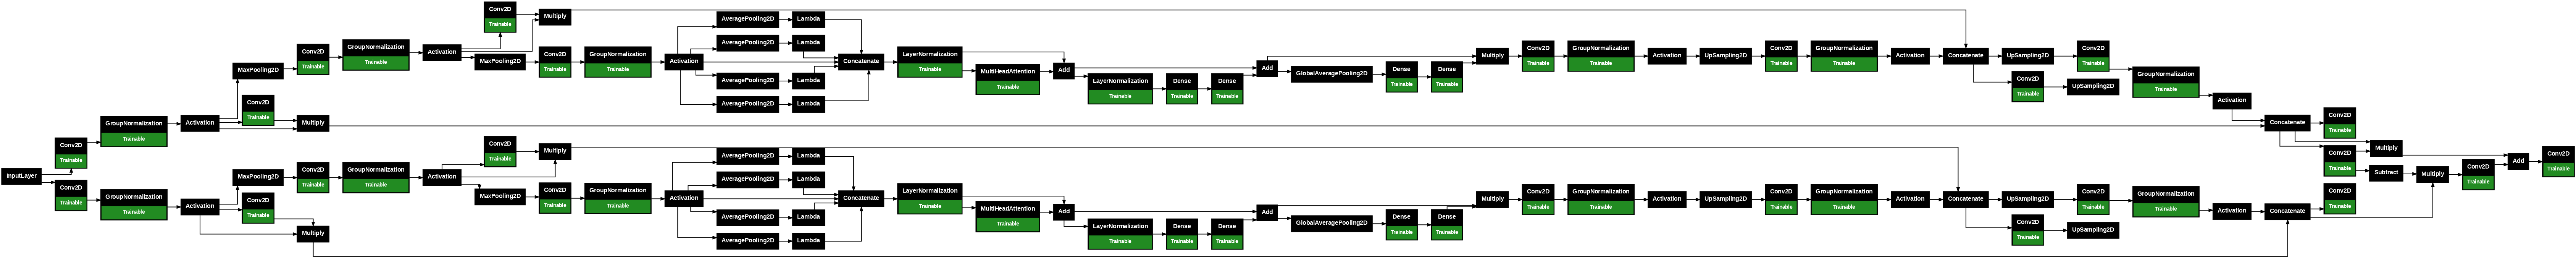

In [ ]:
# UNET
# model = get_unet_model()

# DEEPLABV3
# input_shape = (64, 128, 1)
# model = DeeplabV3Plus(input_shape=input_shape, num_classes=NUM_CLASSES)

# DUAL UNET - transformer
# model = dual_unet_with_transformer()

# DUAL UNET - coarse + fine stream
# model = dual_unet_coarse_fine()

# DUAL UNET - coarse + fine stream + transformer
# model = combined_dual_unet_coarse_fine_transformer()

# DUAL UNET - adaptive norm
# model = combined_dual_unet_adaptive_normalization()

# DEEP SUPERVISION
model = combined_dual_unet_deep_supervision()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70, rankdir='LR')

In [ ]:
print(model.output_names)

ListWrapper(['final_output', 'fine_output3', 'coarse_output3', 'fine_output2', 'coarse_output2'])


In [ ]:
# Compile the model
print("Compiling model...")
model.compile(
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    # loss=sparse_CCC_and_Structural_similarity_loss,
    # loss=combined_loss(class_weights),
    # loss=focal_wrapper_loss,
    # loss=multiclass_dice_loss,
    # loss=focal_dice_loss,
    # loss=surface_loss_keras,
    # loss=focal_dice_sparse_loss([0.4, 0.3, 0.3]),
    # loss=mean_iou_loss,
    # loss=combined_dice_boundary_focal_loss,
    loss={"final_output": focal_wrapper_loss,
          "fine_output3": focal_wrapper_loss,
          "coarse_output3": focal_wrapper_loss,
          "fine_output2": focal_wrapper_loss,
          "coarse_output2": focal_wrapper_loss},
    loss_weights={
        "final_output": 1.0,
        "fine_output3": 0.3,
        "coarse_output3": 0.3,
        "fine_output2": 0.6,
        "coarse_output2": 0.6
    },
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE, weight_decay=1e-4),
    metrics=[["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])],
             ["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])],
             ["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])],
             ["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])],
             ["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

## Train

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
# model_filename = 'UNet.keras'
model_filename = f'DualUnet{final_val_meanIoU}.keras'
model.save(model_filename)

# Delete the model to free up resources
# del model

Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - final_output_accuracy: 0.3206 - final_output_mean_iou: 0.1482 - loss: 0.4179 - val_final_output_accuracy: 0.3614 - val_final_output_mean_iou: 0.2355 - val_loss: 0.2737
Epoch 2/1000
  1/141 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - final_output_accuracy: 0.3202 - final_output_mean_iou: 0.1875 - loss: 0.2347

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: final_output_accuracy,final_output_mean_iou,loss,val_final_output_accuracy,val_final_output_mean_iou,val_loss
  current = self.get_monitor_value(logs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - final_output_accuracy: 0.3668 - final_output_mean_iou: 0.2498 - loss: 0.2869 - val_final_output_accuracy: 0.3946 - val_final_output_mean_iou: 0.2719 - val_loss: 0.2369
Epoch 3/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - final_output_accuracy: 0.4036 - final_output_mean_iou: 0.2886 - loss: 0.2461 - val_final_output_accuracy: 0.4290 - val_final_output_mean_iou: 0.3061 - val_loss: 0.2129
Epoch 4/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - final_output_accuracy: 0.4296 - final_output_mean_iou: 0.3168 - loss: 0.2162 - val_final_output_accuracy: 0.4601 - val_final_output_mean_iou: 0.3370 - val_loss: 0.1937
Epoch 5/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - final_output_accuracy: 0.4492 - final_output_mean_iou: 0.3394 - loss: 0.1928 - val_final_output_accuracy: 0.4817 - val_final_output_mean_iou: 0.3585 - val_loss: 0.1812
Epoch 6/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - final_output_accuracy: 0.4687 - final_output_mean_i

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## OLD

In [ ]:
inputs = tfkl.Input(shape=input_shape)
x = tfkl.Conv2D(filters=num_classes, kernel_size=(1, 1), activation="softmax")(inputs)
model = tfk.Model(inputs=inputs, outputs=x, name="minimal_working_net")

# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=[mean_iou])

model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=1)

In [ ]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# To run if you want to load an already saved model and not the last one trained
model_filename = "DeepLabV3Plus44.01.keras"

In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename, compile=False, safe_mode=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

print(f"Model loaded from {model_filename}")

Model loaded from DualUnet39.33.keras


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

del model

314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

# from google.colab import files
# files.download(submission_filename)

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```